# E-commerce — Выявление профилей потребления

## Шаг. Описание проекта и данных

**Задача:**


Сегментировать покупателей по профилю потребления интернет-магазина товаров для дома и быта "Пока все еще тут".

Т.е. необходимо составить подробные рекомендации заказчику по сегментам покупателей:

- В каком сегменте покупатели покупают часто, много и дорогой товар, а на какой сегмент, возможно, не стоит тратить время
и деньги проводя рассылку.
- Клиентам какого сегмента, когда и какие категории товара рассылать в рекламных предложениях (товар у нас не разбит на
категории, мы сами создаем категории и разносим по ним товар). Как и для какого кластера можно попытаться увеличить
количество продаваемого товара, повысить возвращаемость покупателей и т.д.

**Описание данных**

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки:
- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;

**Загрузка необходимых для работы библиотек**

In [93]:
import pandas as pd
from datetime import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import silhouette_score
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
import warnings; warnings.filterwarnings(action = 'ignore')

**Загрузка датафрейма**

In [94]:
url = "https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv"
df = pd.read_csv(url)

In [95]:
def show_info(df):
    print('Информация о наборе данных:')
    df.info()
    print('---------------------')
    print('Выводим первые 5 строк')
    display(df.head())
show_info(df)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
---------------------
Выводим первые 5 строк


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Датафрейм содержит 7474 строк и 6 колонок. Предварительно видно, что необходимо заменит типы данных для столбца date.

## Шаг. Предобработка данных

На данном этапе необходимо выполнить следующие шаги:

- Исследовать пропущенные значения
- Исследовать соответствие типов и привести к нужным в случае необходимости
- Исследовать дубликаты
- Проверить корректность наименований колонок
- Привести к нижнему регистру
- Заменить пропущенные значения
- Сделать выводы

In [96]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Датафрейм не содержит пропусков

In [97]:
df.dtypes

date             int64
customer_id     object
order_id         int64
product         object
quantity         int64
price          float64
dtype: object

Заменим тип данных для столбца date

In [98]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d%H")
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Проверим явные и неявные дубликаты

In [99]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим неявные, предполагая, что одному идентификатора заказа (order_id) соотвествует одно наименование товара (product).

In [100]:
df[df.duplicated(['order_id', 'product'])]

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Удалим дубликаты, сохраняя последнее значение, так как заказ могли просто переоформить с тем же идентификатором или он мог быть случайно загружен повторно.

In [101]:
df_filtered = df.drop_duplicates(subset=['order_id', 'product'], keep='last')

Првоверим, соответствует ли идентификатору заказа одна уникальная дата.

In [102]:
df_filtered.groupby('order_id').agg({'date':'nunique'}).sort_values(by='date',ascending=False).head(20)

,date
order_id,
68760,3
14649,2
70186,2
70318,2
71143,2
14500,2
14897,2
71426,2
69527,2


Некоторым заказам соответствует несколько дат. Посмотрим пример ниже

In [103]:
df_filtered.query('order_id==68760')

,date,customer_id,order_id,product,quantity,price
416,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка деревянная с расширенными плечиками и ...,8,262.0
418,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка с закругленными плечиками без переклад...,7,106.0
423,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой большой, 30*40*25 с...",1,674.0
424,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой малый, 28*30*16 см,...",3,524.0
427,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Набор вешалок мягких тканевых с перекладиной 3...,2,277.0
435,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Швабра САЛЬСА треугольная МИНИ, Y8110",1,524.0
463,2018-10-27 23:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Гладильная доска Sarayli Tamara 125x42 см,1,3074.0
515,2018-10-29 17:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка для блузок 41 см черный Attribute AHM791,9,50.0
516,2018-10-29 17:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 50х80 см Ста...,1,299.0
517,2018-10-29 17:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 60х90 см Ста...,1,412.0


В целом, не будем ничего делать с этими заказами - товары не повторяются. Их не много.

In [104]:
len(df) - len(df_filtered)
print('удалили строк:', len(df) - len(df_filtered))

удалили строк: 1920


Теперь проверим, есть ли идентификаторы заказов, в которых идентификаторов клиентов больше 1.

In [105]:
df_filtered.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1')

,customer_id
order_id,
69485,2


In [106]:
df_filtered.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0


Скорее всего это ошибка. Но оставим, как есть.

Также приведем к нижнему регистру строки столбца product

In [107]:
df_filtered['product'] = df_filtered['product'].str.lower()

**Выводы:**
- пропусков в данных не обнаружено
- колонка date приведены к типу данных дата
- удалены 1920 строк неявных дубликатов, исходя из того, что в каждом заказе (order_id)  наименование товара (product) не повторяется
- названия колонок корректны и соответствуют данным, которые содержат
- строки столбца product приведены к нижнему регистру

## Шаг. Исследовательский анализ данных

На данном этапе сделаем следующее:
- Выведем описательную статистику
- Разберемся с выбр
- Добавим необходимые метрики для дальнейшего анализа
- 
- Посмотрим на выбросы в данных. Построим столбчатые гистограммы и распределения признаков
- Построим корреляционную матрицу
- Сделаем выводы

### Добавление новых переменных

Добавим колонку со стоимостью по каждой позиции (product) в заказе

In [108]:
df_filtered['total_price'] = df_filtered['price'] * df_filtered['quantity'] 

Добавим столбец со стоимостью всего заказа

In [109]:
df_filtered['order_price'] = df_filtered.groupby('order_id')['total_price'].transform('sum')

Добавим также столбец с количеством единиц товаров в заказе

In [110]:
df_filtered['order_quantity'] = df_filtered.groupby('order_id')['quantity'].transform('sum')

Добавим также столбец с количеством товаров в заказе

In [111]:
df_filtered['order_products'] = df_filtered.groupby('order_id')['product'].transform('count')

Также добавим дату оформления заказа в формате без часа оформления заказа + месяц и год оформления заказа для отслеживания сезонности.

In [112]:
df_filtered['date_ymd'] = df_filtered['date'].dt.date
df_filtered['date_ymd'] = pd.to_datetime(df_filtered['date_ymd'])
df_filtered['month'] = df_filtered['date_ymd'].dt.month
df_filtered['year'] = df_filtered['date_ymd'].dt.year
df_filtered['year_month'] = df_filtered['date_ymd'].dt.to_period("M")


Добавим столбец с количество заказов на человека + средний чек

In [113]:
orders_per_customer_df = df_filtered.groupby('customer_id')['order_id'].nunique().reset_index(name='orders_per_customer')
df_filtered = df_filtered.merge(orders_per_customer_df, on='customer_id', how='left')

avg_bill_per_customer_df = df_filtered.groupby('customer_id').agg({'total_price': 'sum', 'order_id': 'nunique'}).reset_index()
avg_bill_per_customer_df['avg_bill_per_customer'] = avg_bill_per_customer_df['total_price'] / avg_bill_per_customer_df['order_id']

df_filtered = df_filtered.merge(avg_bill_per_customer_df[['customer_id', 'avg_bill_per_customer']], on='customer_id', how='left')

Теперь определим лояльных клиентов как тех клиентов, которые совершили более одного заказа за период наблюдений.

In [114]:
df_filtered.groupby(['customer_id', 'order_id'])['date'].nunique().value_counts()

1    3507
2      14
3       1
Name: date, dtype: int64

Кажется, что большинство клиентов совершают по одному заказу в день, однако есть и исключения. Но все равно будем считать лояльными тех, кто совершил > 1 заказа.

In [115]:
# Запишем в наш датафрейм лояльных клиентов как 1. Тех, кто совершил только 1 заказ как 0.

df_new = df_filtered.query('orders_per_customer >1')
df_new = df_new.drop_duplicates(subset='order_id')


df_filtered['loyal'] = 0

for index, row in df_filtered.iterrows():
    if row['customer_id'] in df_new['customer_id'].values:
        df_filtered.at[index, 'loyal'] = 1

In [116]:
# Теперь посчитатем количество дней с предыдущего заказа для лояльных клиентов

loyal_cus = df_filtered[df_filtered['loyal'] == 1].sort_values(by=['date_ymd', 'customer_id'])
loyal_cus = loyal_cus.drop_duplicates(subset='order_id')

loyal_cus.sort_values(by=['date_ymd', 'customer_id', 'order_id'], inplace=True)
loyal_cus['days_since_previous_order'] = loyal_cus.groupby('customer_id')['date_ymd'].diff().dt.days

# Добавим данные в наш датафрейм
df_filtered = df_filtered.merge(loyal_cus[['customer_id', 'order_id', 'days_since_previous_order']], 
                                on=['customer_id', 'order_id'], how='left')

Сделаем категории для товаров

In [117]:
home_flowers = ['пеларгония', 'домашняя', 'адиантум', 'азалия', 'алоэ', 'антуриум', 'аптения', 'амариллис',\
               'альбука', 'артемизия', 'аспарагус', 'афеляндра', 'циперус', 'декабрист',\
               'хлорофитум', 'мединилла', 'примула', 'комнатное растение', 'роза кордана', 'фиалка', 'эхеверия',\
                'роза патио', 'мирт', 'роза мини', 'калатея', 'пуансеттия', 'пуансетия', 'эхинокактус', 'гардения',\
               'лавр', 'диффенбахия', 'спатифиллум', 'цикламен', 'муррайя', 'шеффлера','хамедорея', 'нолина', 'гербера',\
               'подарочный набор на 8 марта тюльпаны', 'нефролепис', 'гиацинт', 'хризантема', 'соланум', 'цитрофортунелла',\
               'хризолидокарпус', 'дендробиум', 'юкка', 'фикус', 'крокус', 'глоксиния', 'каланхое', 'крассула',\
               'замиокулькас', 'фатсия', 'джункус', 'роза палас', 'импатиенс', 'гимнокалициум', 'литопс',\
                'эпипремнум', 'капсикум', 'скиммия', 'пахира', 'калоцефалус', 'драцена', 'радермахера', 'фиттония', 'пеперомия', 'каллуна']
trolleys_bags = ['тележк', 'сумк']
repairs = ['стремянк', 'лестница', 'стяжка', 'крепеж', 'пружина', 'петля', 'свер', 'шпагат', 'угол',\
'линейка', 'крючок проволочный', 'ручка-скоба', 'завертка', 'шпингалет', 'фиксатор-шар', 'штангенциркуль',\
'термометр', 'ручка', 'сварка', 'бензин', 'веревка', 'фал капроновый', 'инструмент', 'для полировки', 'шнур', 'решетка вентиляционная',\
          'напильник', 'основание для пробки', 'насадка на валик']
interior = ['искуственн', 'искусствен' 'светиль', 'кашпо', 'ваза', 'муляж', 'искусственн', 'ключница', 'декор', 'светильник', 'фоторамка']
textile = ['простыня', 'ковр', 'скатерть', 'штор', 'плед', 'полотенц', 'подушк', 'салфет',\
'ковёр', 'ковер', 'постельное белье', 'наматрицник', 'наматрасник', 'наматрацник', 'простынь',\
'одеяло', 'покрывало', 'халат', 'наволочка', 'пододеяльник', 'полотенец']
bathroom = ['ёрш', 'ерш','карниз для ванной', 'штанга для ванной', 'cиденье в ванну', 'для ванн', 'сиденье в ванну',\
            'подголовник', 'дозатор', 'мыльница', 'сиденье для унитаза', 'для ванной комнаты', 'держатель для туалетной бумаги']
care_clothes_shoes = ['гладиль', 'прищеп', 'сушилка', 'крючок одежный', 'мешок для деликатной стирки',\
'подрукавника', 'чехол для', 'подкладка под чехол', 'подлокотник', 'подрукавник', 'ролик', 'одежд', 'гардероб',\
                     'вакуум', 'брюк', 'юбок', 'плечик', 'блуз', 'костюм', 'вешалки мягкие', 'чехол', 'набор вешалок',\
                     'сетка для глажения', 'шило', 'вешалка самоклеющая', 'сетка для стирки белья',\
                     'кондиционер для белья', 'для стирки белья']
furniture = ['комод', 'полк', 'подставка', 'стеллаж', 'этажерка', 'пуф', 'обувница', 'напол', 'настен', 'слуга',\
            'вешалка-перекладина', 'вешалка металлическая', 'вешалка надверная', 'вешалка-стойка']
appliances = ['миксер', 'весы', 'чайник электрич', 'электроштопор', 'соковарка', 'овощеварка', 'кипятильник',\
             'пылесос', 'фен', 'мантоварка', 'пароварка', 'утюг']
cleaning = ['перчатки', 'таз ', 'щетка','антинакипин', 'ведро',\
 'антижир','вантуз', 'веник', 'микрофибр', 'сметка', 'средство', 'швабра',\
            'окномойка','совок', 'скребок', 'мыть', 'насадка для ведра', 'мусор', 'насадка-моп',\
           'губка', 'посудомоеч', 'отжим', 'чистящий крем', 'щётка для унитаза', 'ткань для окон', 'тряпкодержатель', 'ткань для гигиенических поверхностей']
dishes_others = ['чайник эмал', 'термос', 'чайник со свистком', 'термокружка']
dishes_serv = ['тарелка', 'вилка', 'нож', 'ложка', 'кружк', 'фужер', 'кувшин','блюд', 'бульонница',\
'емкость для соуса', 'бокал', 'стакан', 'салатник', 'кружек', 'чайный набор', 'чайник завар', 'сахарница', 'набор столовых приборов']
dishes_coocking = ['сковород', 'толкушка', 'противень', 'сотейник','кастрюля', 'венчик',\
'емкость для свч', 'выпечк', 'ковш', 'лоток для холодца', 'лопатка', 'форм для кексов',\
 'миска', 'половник', 'терка', 'шприц', 'скалка', 'разделочная', 'соковыжим', 'отделитель косточек', 'орехокол',\
                  'сито', 'пресс для чеснока', 'картофелемялка', 'рыбочистка металлическая', 'овощечистка', 'просеиватель для муки', 
                  'контейнер для приготовления']
dishes_storage = ['контейнер для свч', 'контейнер для овощей', 'масленка', 'контейнер для продуктов', 'хлебница', 'тортница']

seedlings_cuttings = ['рассада', 'в кассете', 'черенок', 'аквилегия', 'алиссум', 'анемона', 'астра', 'бадан', 'бальзамин',\
                     'барвинок', 'бегония', 'вербейник', 'вербена', 'буддлея', 'бузульник', 'вероника', 'калибрахоа',\
                      'петуния', 'ель', 'фуксия', 'эвкалипт', 'овсянница', 'колокольчик', 'котовник', 'роза садовая',\
                     'мимоза', 'лобелия', 'гвоздика', 'лаванда', 'ясколка', 'клен', 'нивянник', 'чабер',\
                     'физостегия', 'гипсофила', 'седум', 'камнеломка', 'кореопсис', 'энотера', 'лапчатка',\
                     'молодило', 'лен', 'виола', 'платикодон','ранункулус', 'кипарисовик', 'кампанула',\
                     'лантана', 'осина', 'пиретрум робинсон', 'хоста', 'флокс', 'калла', 'роза чайно-гибридная восточный экспресс',\
                     'гортензия', 'солидаго', 'монарда', 'подсолнечник', 'мускари', 'эхинацея', 'лилейник', 'сантолина',\
                     'рудбекия', 'гайлардия', 'гелихризум', 'подвесное кашпо']
seedlings_fruit_veg = ['арбуз', 'базилик', 'томат', 'тимьян', 'дыня', 'клубника', 'кофе', 'розмарин', 'виноград',\
                      'мята', 'душица', 'земляника', 'иссоп', 'кабачок', 'патиссон', 'тыкв', 'мелисса', 'прян',\
                       'огурца', 'огурец', 'кабачк', 'капуст', 'зелен', 'дыни', 'клубники', 'петрушка', 'перца', 'лук', 'сельдерей', 'баклажан']
hygiene = ['мыло', 'пена', 'зубная', 'увлажн']
seeds = [' г ', 'цинния ацтек', '46', 'тюльпан louvre']
storage = [' бак ', 'для хранения', 'кофр', 'корзин', 'коробка', 'лоток', 'короб']
garden_dacha = ['ванна 70 л оцинкованная', 'корыто', 'ящик почтовый', 'крышка оцинкованная для стерилизации банок',\
          'банка', 'бидон', 'пьезозажигалка', 'котел', 'урна', 'пикник', 'набор посуды из нержавеющей стали']
flowers_plantation = ['плантация']

In [118]:
df_filtered['category'] = 'others'

for index, row in df_filtered.iterrows():
    product = row['product']
    # Преобразуйте в нижний регистр для более точного сравнения
    if any(word in product for word in care_clothes_shoes):
        df_filtered.at[index, 'category'] = 'care_clothes_shoes'
    

    elif any(word in product for word in interior):
        df_filtered.at[index, 'category'] = 'interior'
    elif any(word in product for word in dishes_coocking):
        df_filtered.at[index, 'category'] = 'dishes_coocking'
    elif any(word in product for word in dishes_others):
        df_filtered.at[index, 'category'] = 'dishes_others'
    elif any(word in product for word in dishes_serv):
        df_filtered.at[index, 'category'] = 'dishes_serv'
    
    elif any(word in product for word in dishes_storage):
        df_filtered.at[index, 'category'] = 'dishes_storage'
    elif any(word in product for word in bathroom):
        df_filtered.at[index, 'category'] = 'bathroom'
    elif any(word in product for word in cleaning):
        df_filtered.at[index, 'category'] = 'cleaning'
    elif any(word in product for word in textile):
        df_filtered.at[index, 'category'] = 'textile'
    elif any(word in product for word in care_clothes_shoes):
        df_filtered.at[index, 'category'] = 'care_clothes_shoes'
    elif any(word in product for word in repairs):
        df_filtered.at[index, 'category'] = 'repairs'
    elif any(word in product for word in hygiene):
        df_filtered.at[index, 'category'] = 'hygiene'
    elif any(word in product for word in trolleys_bags):
        df_filtered.at[index, 'category'] = 'trolleys_bags'
    elif any(word in product for word in storage):
        df_filtered.at[index, 'category'] = 'storage'
    elif any(word in product for word in appliances):
        df_filtered.at[index, 'category'] = 'appliances'
    elif any(word in product for word in furniture):
        df_filtered.at[index, 'category'] = 'furniture'
    elif any(word in product for word in garden_dacha):
        df_filtered.at[index, 'category'] = 'garden_dacha'
    elif any(word in product for word in seeds):
        df_filtered.at[index, 'category'] = 'seeds'
    elif any(word in product for word in home_flowers):
        df_filtered.at[index, 'category'] = 'home_flowers'
    elif any(word in product for word in seedlings_fruit_veg):
        df_filtered.at[index, 'category'] = 'seedlings_fruit_veg'
    elif any(word in product for word in seedlings_cuttings):
        df_filtered.at[index, 'category'] = 'seedlings_cuttings'
    elif any(word in product for word in flowers_plantation):
        df_filtered.at[index, 'category'] = 'flowers_plantation'
        
# Проверим все ли распределили
len(df_filtered.query('category == "others"'))

0

Все категории заполнены

In [119]:
df_filtered.head()

,date,customer_id,order_id,product,quantity,price,total_price,order_price,order_quantity,order_products,date_ymd,month,year,year_month,orders_per_customer,avg_bill_per_customer,loyal,days_since_previous_order,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,1037.0,7,7,2018-10-01,10,2018,2018-10,1,1037.0,0,NaN,home_flowers
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,1037.0,7,7,2018-10-01,10,2018,2018-10,1,1037.0,0,NaN,home_flowers
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,1037.0,7,7,2018-10-01,10,2018,2018-10,1,1037.0,0,NaN,home_flowers
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,1037.0,7,7,2018-10-01,10,2018,2018-10,1,1037.0,0,NaN,home_flowers
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,1037.0,7,7,2018-10-01,10,2018,2018-10,1,1037.0,0,NaN,home_flowers


### Предварительный анализ категорий товаров

Подготовим данные

In [120]:
categories = df_filtered.groupby('category').agg({'product':'nunique', 'price':'median', 'order_price':['sum', 'median'],
                                                 'avg_bill_per_customer':'median', 'orders_per_customer':'median'}).reset_index()
categories.columns = ['category', 'product_unique_cnt', 'median_price_for_product', 'revenue_for_category', 'median_price_for_order',
                     'avg_bill_per_customer', 'avg_orders_per_customer']
categories

,category,product_unique_cnt,median_price_for_product,revenue_for_category,median_price_for_order,avg_bill_per_customer,avg_orders_per_customer
0,appliances,30,862.0,5.478900e+04,940.5,1034.00,2.0
1,bathroom,98,899.0,2.096760e+05,974.0,974.00,2.0
2,care_clothes_shoes,312,599.0,1.119884e+06,749.0,855.50,2.0
3,cleaning,136,239.0,1.099188e+06,564.0,928.00,2.0
4,dishes_coocking,62,220.5,1.029435e+05,411.0,686.00,2.0
5,dishes_others,18,577.0,1.886600e+04,584.0,584.00,2.0
6,dishes_serv,144,149.0,3.616945e+05,567.0,888.00,1.0
7,dishes_storage,10,307.0,1.425500e+04,524.0,636.50,2.0
8,flowers_plantation,4,93.0,7.611000e+03,1733.0,1733.00,1.0
9,furniture,43,1349.0,1.197210e+05,1425.0,1222.00,2.0


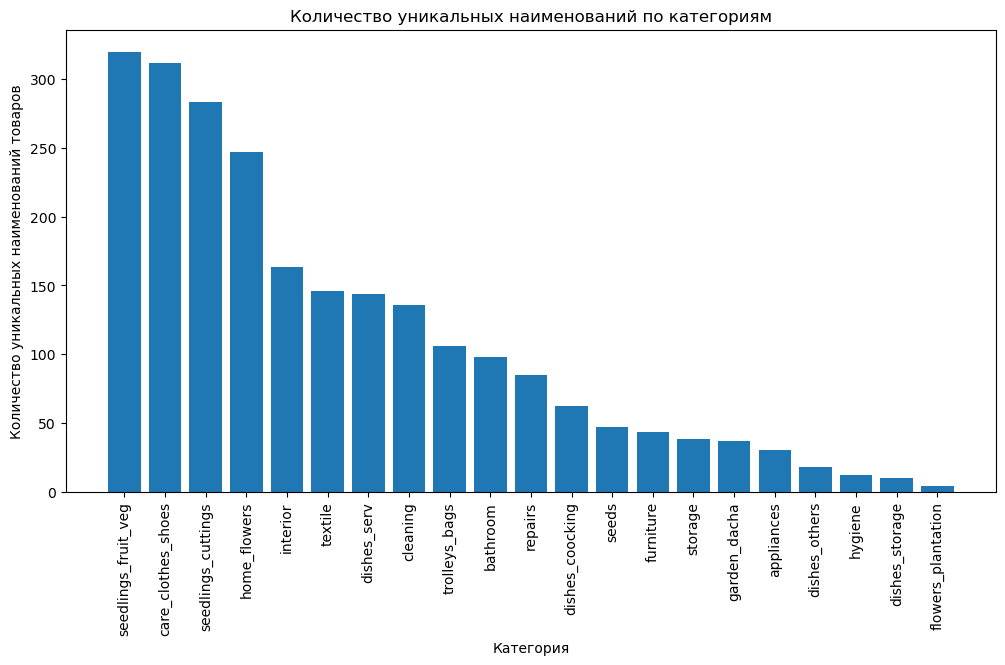

In [121]:
# График 1: Столбчатая диаграмма для количества уникальных продуктов по категориям
plt.figure(figsize=(12, 6))
plt.bar('category', 'product_unique_cnt', data=categories.sort_values(by='product_unique_cnt', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Категория')
plt.ylabel('Количество уникальных наименований товаров')
plt.title('Количество уникальных наименований по категориям')
plt.show()

Как видно из графика - больше всего уникальных наименований товаров в следующих категориях: seedlings_fruit_veg (рассада овощей и фруктов), care_clothes_shoes (товары по уходу за одеждой и обувью), а также в категории seedlings_cuttings (рассада растений и черенки), на 4-м месте категория home_flowers (домашние цветы). Остальные категории существенно меньше содержат уникальных наименований товаров.

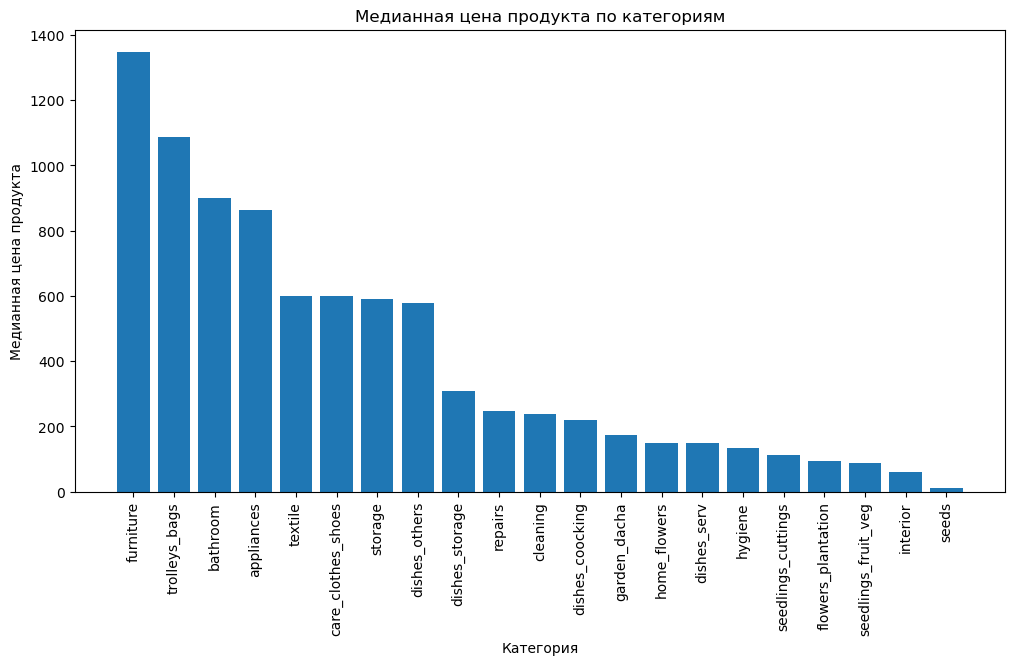

In [122]:
# График 2: График разброса для медианной цены продукта по категориям
plt.figure(figsize=(12, 6))
plt.bar('category', 'median_price_for_product', data=categories.sort_values(by='median_price_for_product', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Категория')
plt.ylabel('Медианная цена продукта')
plt.title('Медианная цена продукта по категориям')
plt.show()

- Самый дорогой товар в категориях: furniture (мебель), trolleys_bags (сумки и тележки)
- А вот категрии с цветами и рассадой отличаются очень низкой медианной ценой товаров

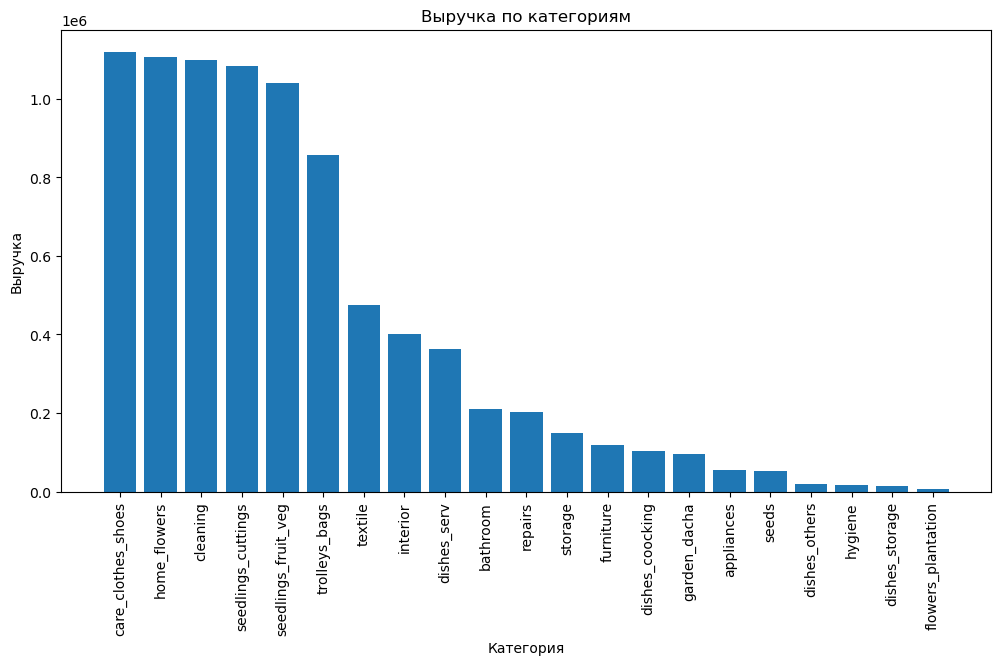

In [123]:
# График 3: Столбчатая диаграмма для выручки по категориям
plt.figure(figsize=(12, 6))
plt.bar('category', 'revenue_for_category', data=categories.sort_values(by='revenue_for_category', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Категория')
plt.ylabel('Выручка')
plt.title('Выручка по категориям')
plt.show()

- Больше всего денег принесла категории: care_clothes_shoes (товары по уходу за одеждой и обувью), cleaning (товары для уборки), home_flowers (домашние цветы), seedlings_fruit_veg (рассада овощей и фруктов)
- Меньше всего денег: flowers_plantation (цветы плантационные), dishes_storage (посуда для хранения), dishes_others (посуда другое) и hygiene (товары для гигиены).

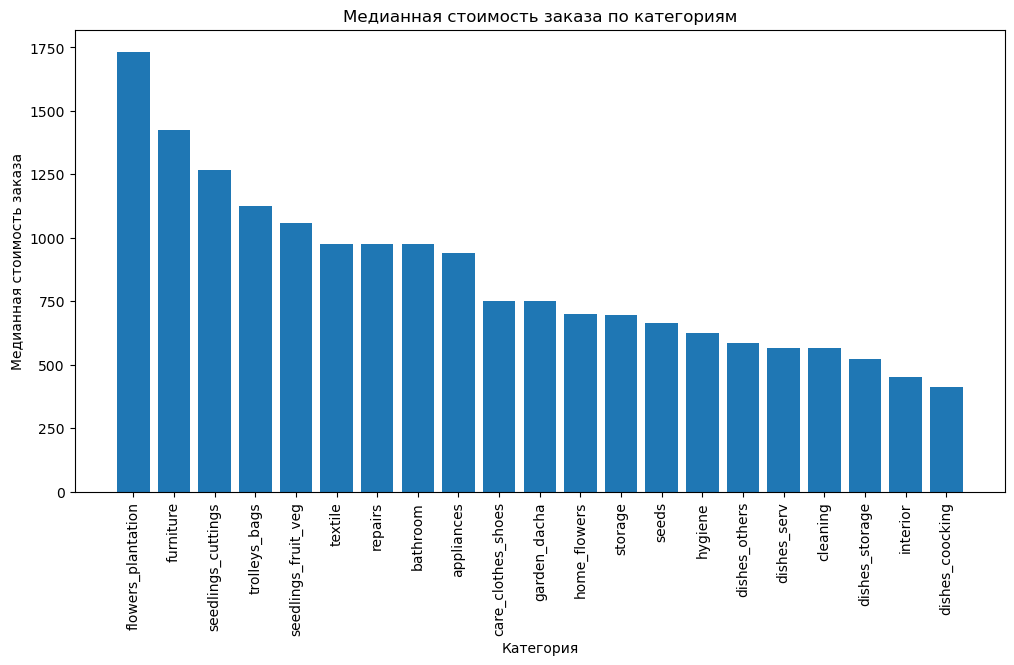

In [124]:
# График 5: Столбчатая диаграмма для медианной стоимости заказа
plt.figure(figsize=(12, 6))
plt.bar('category', 'median_price_for_order', data=categories.sort_values(by='median_price_for_order', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Категория')
plt.ylabel('Медианная стоимость заказа')
plt.title('Медианная стоимость заказа по категориям')
plt.show()

- Самая небольшая категория по выручке flower_plantation имеет самую высокую медианную стоимость заказа (может быть есть несколько оптовых покупателей в этой категории?)
- Мебель - на втором месте, что логично, так как товары из этой категории имеют высокую цену
- Seedling&cuttings (рассада растений и черенки) на третьем месте (возможно из=за того, что в заказе может быть несколько позиций)

### Анализ топа-10 товаров из категорий

In [125]:
# Группируем данные и находим топ-10 продуктов для каждой категории
top10_products = df_filtered.groupby('category')['product'].value_counts().groupby('category').head(10)

# Итерируемся по категориям и выводим топ-10 продуктов для каждой категории
for category, products in top10_products.groupby(level=0):
    print(f"Category: {category}")
    print(products)

Category: appliances
category    product                                                                                
appliances  овощеварка алюминиевая scovo мт-045, хозлэнд, 1502079                                      5
            весы электронные кухонные soehnle (круглые,20 см. стеклянные) серебро 5кг/1гр. 66161       3
            чайник электрический василиса т30-2000 нержавеющая сталь черный c красным 2000 вт 1,8 л    3
            весы напольные edition feet механические                                                   2
            весы напольные электронные soehnle pino white, 63747                                       2
            диффенбахия камилла d-12 см                                                                2
            миксер delta lux dl-5068 серо-голубой 400 вт 4 насадки 5 скоростных режимов турборежим     2
            миксер электрический погружной delta dl-5061 белый с сиреневым 300 вт 5 скоростей          2
            чайник электрический аксинь

- В категории appliances (бытовая техника) больше всего продаж у овощеварки. В целом, категория содержит больше товаров для кухни (чайники, кухонные весы)
- В категории bathroom лидирует по продажам ёрш, а также продаются лучше всего сиденье для унитаза и шторы/карнизы для ванной
- В категории care_clothes_shoes лидируют сушилки и гладильные доски
- В категории cleaning - тазы
- В категории dishes_cooking (посуда для приготовления еды) товары разнообразны - миски, терки, доски
- В категории dishes_others представлены эмалированные чайники и термосы
- В категории dishes_serv представлены кувшины, салатницы, вилки, ложки и т.д.
- В категории dishes_storage представлены контейнеры для хранения еды, масленки, хлебницы
- В категории flowers_plantation представлены цветы с плантации (розы)
- В категории furniture (мебель) представлены полки, этажерки
- В категории garden_daсha собраны товары: банки, корыта
- В категории home_flowers собраны в основном пеларгонии
- В категории hygiene представлены мыло и зубная паста
- В категории interior: муляжи и искуственные цветы
- В категории ремонта (repair): стяжки, лестницы и стремянки
- В категории seedlings&cuttings (рассада растений и черенки) собраны петунии, елки и калибрахоа 
- seedlings_fruit_veg: рассада зелени в основном
- seeds (семена): семена растений и зелени
- storage (хранение): корзины для белья
- textile: коврики, скатерти, салфетки
- trolleys_bags: сумки и тележки

### Анализ распределения и выбросов

Для начала выполним описательную статистику

In [126]:
df_filtered[['quantity', 'price', 'total_price', 'order_price', 'order_quantity', 'orders_per_customer',
            'avg_bill_per_customer', 'loyal', 'days_since_previous_order']].describe()

,quantity,price,total_price,order_price,order_quantity,orders_per_customer,avg_bill_per_customer,loyal,days_since_previous_order
count,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,5554.000000,1303.000000
mean,2.586244,531.639194,830.953262,1546.306341,8.567339,4.998380,1537.822004,0.424559,151.158864
std,16.470806,974.301212,9198.016525,9355.713190,20.092490,19.930651,9329.588882,0.494320,139.358973
min,1.000000,9.000000,9.000000,9.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,90.000000,120.000000,374.000000,1.000000,1.000000,445.875000,0.000000,2.000000
50%,1.000000,150.000000,191.000000,893.000000,2.000000,1.000000,939.000000,0.000000,150.000000
75%,1.000000,524.000000,734.000000,1724.000000,10.000000,2.000000,1636.514286,1.000000,289.000000
max,1000.000000,14917.000000,675000.000000,675000.000000,1000.000000,126.000000,675000.000000,1.000000,395.000000


**Выводы:**

- Количество единиц товаров (quantity):
Среднее значение количества единиц товаров равно примерно 2.59, но медианное значение (50-й процентиль) составляет всего 1. Это может указывать на смещенное распределение с тяжелым правым хвостом, где большинство заказов содержит небольшое количество товаров, но есть также несколько заказов с очень большим количеством товаров.
- Цена товаров (price):
Средняя цена товара составляет примерно 531.64, а минимальная цена - 9. Это также может указывать на смещенное распределение, где большинство товаров имеют низкую цену, но есть несколько товаров с очень высокой ценой.
- Стоимость товара (total_price) и цена заказа (order_price):
Среднее значение стоимости товара и цены заказа существенно выше медианы, что может свидетельствовать о наличии выбросов или нескольких заказах с очень высокими значениями. Стандартное отклонение также велико, что также может указывать на наличие больших различий между заказами.
- Количество товаров в заказе заказов (order_quantity):
Среднее значение количества товаров в заказе на клиента составляет примерно 8.57, но медианное значение равно всего 2. Это может указывать на наличие клиентов, совершающих много заказов, что может быть интересным для анализа лояльности клиентов.
- Дни между предыдущими заказами (days_since_previous_order):
Среднее значение составляет примерно 151.16 дней, но стандартное отклонение значительно выше. Это может указывать на наличие выбросов в данных, где некоторые клиенты совершают заказы с большими интервалами между ними.
- Лояльность (loyal):
Это бинарный признак, где 1 указывает на лояльных клиентов, а 0 - на нелояльных. Согласно описательной статистике, примерно 42.46% клиентов считаются лояльными (среднее значение).
- Средний чек на клиента (avg_bill_per_customer):
Средний чек на клиента имеет разнообразное распределение с большим разбросом (стандартное отклонение высоко). Среднее значение составляет примерно 1537.82, но медианное значение меньше. Это может указывать на наличие заказов с очень высокими значениями среднего чека.

Посмотрим на гистограммы для каждого числового признака 

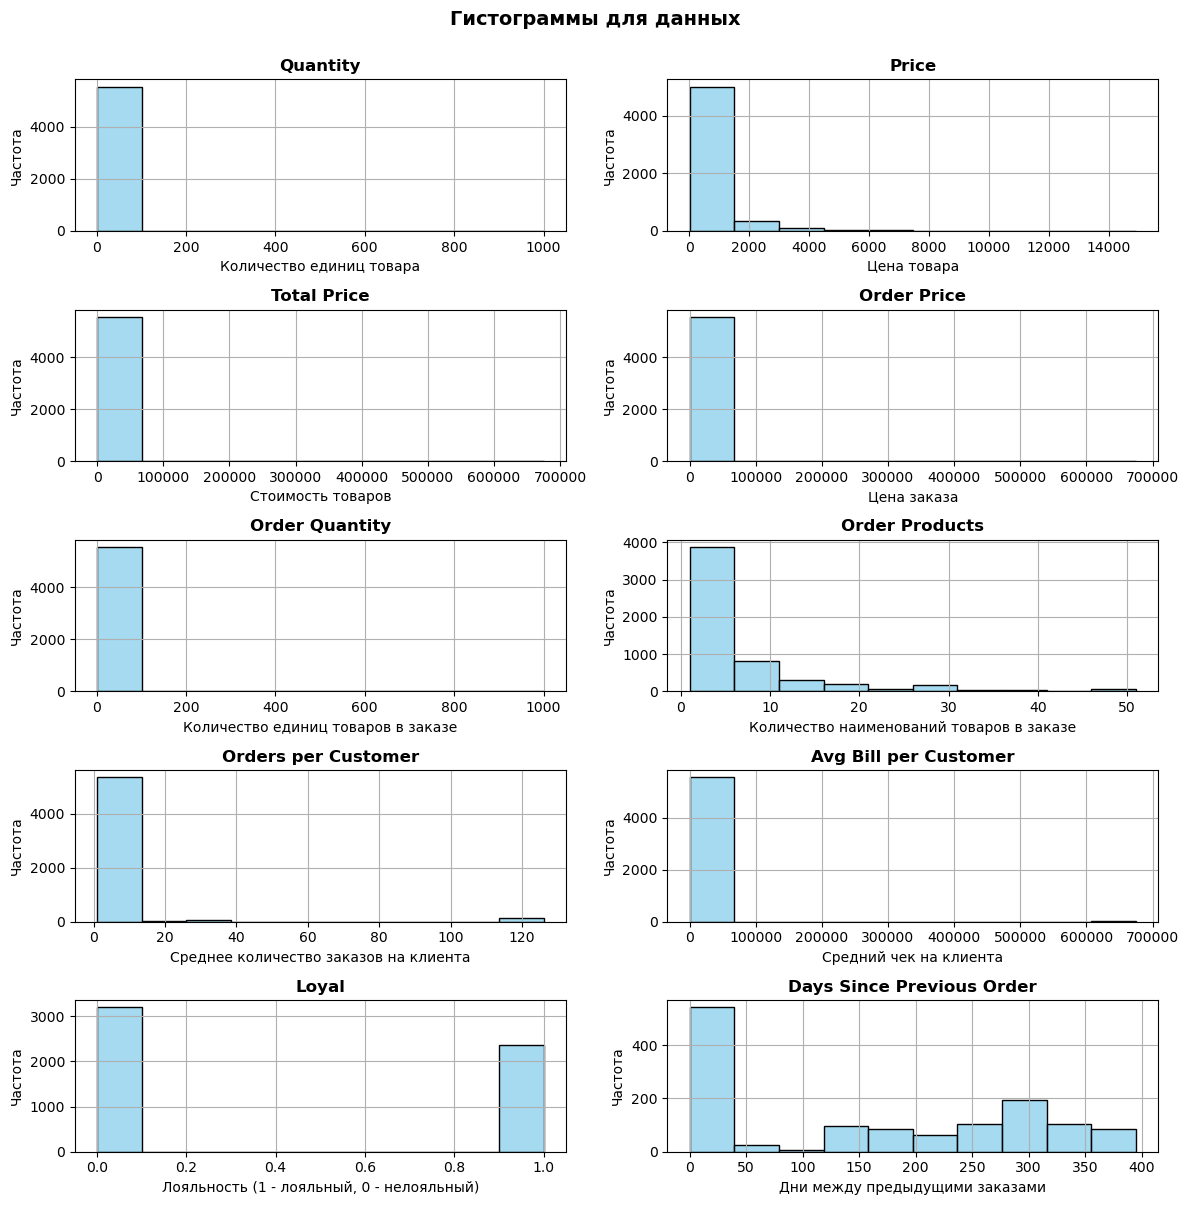

In [127]:
# Создаем подграфики с заданным числом строк и столбцов
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))

# Список для группировок и соответствующих названий
columns = [
    ('quantity', 'Quantity', 'Количество единиц товара'),
    ('price', 'Price', 'Цена товара'),
    ('total_price', 'Total Price', 'Стоимость товаров'),
    ('order_price', 'Order Price', 'Цена заказа'),
    ('order_quantity', 'Order Quantity', 'Количество единиц товаров в заказе'),
    ('order_products', 'Order Products', 'Количество наименований товаров в заказе'),
    ('orders_per_customer', 'Orders per Customer', 'Среднее количество заказов на клиента'),
    ('avg_bill_per_customer', 'Avg Bill per Customer', 'Средний чек на клиента'),
    ('loyal', 'Loyal', 'Лояльность (1 - лояльный, 0 - нелояльный)'),
    ('days_since_previous_order', 'Days Since Previous Order', 'Дни между предыдущими заказами')
]

# Цикл для построения гистограмм
for i, (column, title, description) in enumerate(columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.histplot(df_filtered[column], bins=10, color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(description, fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)
    ax.grid(True)


fig.suptitle('Гистограммы для данных', fontsize=14, fontweight='bold', y=1)


plt.tight_layout()


plt.show()


**Выводы:**
- Мы получили подтверждение, что данные скошены в левую сторону
- Больше 100 единиц товара в заказе - это выбросы
- Цена товара > 4000 тыс. скорее всего тоже выбросы
- Стоимость товара не бывает > 100 тыс.
- Стоимость заказа не бывает > 100 тыс.
- Количество товаров в заказе > 100 - выбросы
- Количество заказов на клиента > 20 - это выбросы
- С днями после последного заказа сложно сказать по данному графику

Посмотрим выбросы по стоимости заказов

### Удаление выбросов

При помощи метода quantile получим соответствующую нижнюю и верхнюю границы, а затем выводим количество выбросов для каждого столбца

In [128]:
numeric_columns = ['quantity', 'price', 'total_price', 'order_price', 'order_quantity', 'order_products', 'orders_per_customer',
            'avg_bill_per_customer', 'loyal', 'days_since_previous_order']

In [129]:
for column in numeric_columns:
    lower_bound = df_filtered[column].quantile(q=0.025)
    upper_bound = df_filtered[column].quantile(q=0.975)
    filtered_data = df_filtered[(df_filtered[column] < lower_bound) | (df_filtered[column] > upper_bound)]
    print(f"Выбросы в колонке {column}:")
    display(len(filtered_data))
    print(f"Нижняя граница {lower_bound}, верхняя граница {upper_bound}")
    print('----------')

Выбросы в колонке quantity:


130

Нижняя граница 1.0, верхняя граница 12.0
----------
Выбросы в колонке price:


261

Нижняя граница 22.0, верхняя граница 3452.4125000000035
----------
Выбросы в колонке total_price:


275

Нижняя граница 29.0, верхняя граница 4117.0
----------
Выбросы в колонке order_price:


275

Нижняя граница 44.82500000000002, верхняя граница 5249.0
----------
Выбросы в колонке order_quantity:


136

Нижняя граница 1.0, верхняя граница 47.0
----------
Выбросы в колонке order_products:


118

Нижняя граница 1.0, верхняя граница 30.0
----------
Выбросы в колонке orders_per_customer:


0

Нижняя граница 1.0, верхняя граница 126.0
----------
Выбросы в колонке avg_bill_per_customer:


278

Нижняя граница 81.91250000000001, верхняя граница 4562.450000000003
----------
Выбросы в колонке loyal:


0

Нижняя граница 0.0, верхняя граница 1.0
----------
Выбросы в колонке days_since_previous_order:


32

Нижняя граница 0.0, верхняя граница 377.0
----------


Если мы удалим согласно этому выбросы, то это может исказить данные.
Построим boxplot и по итогам решим, сколько данных и каких удалить.

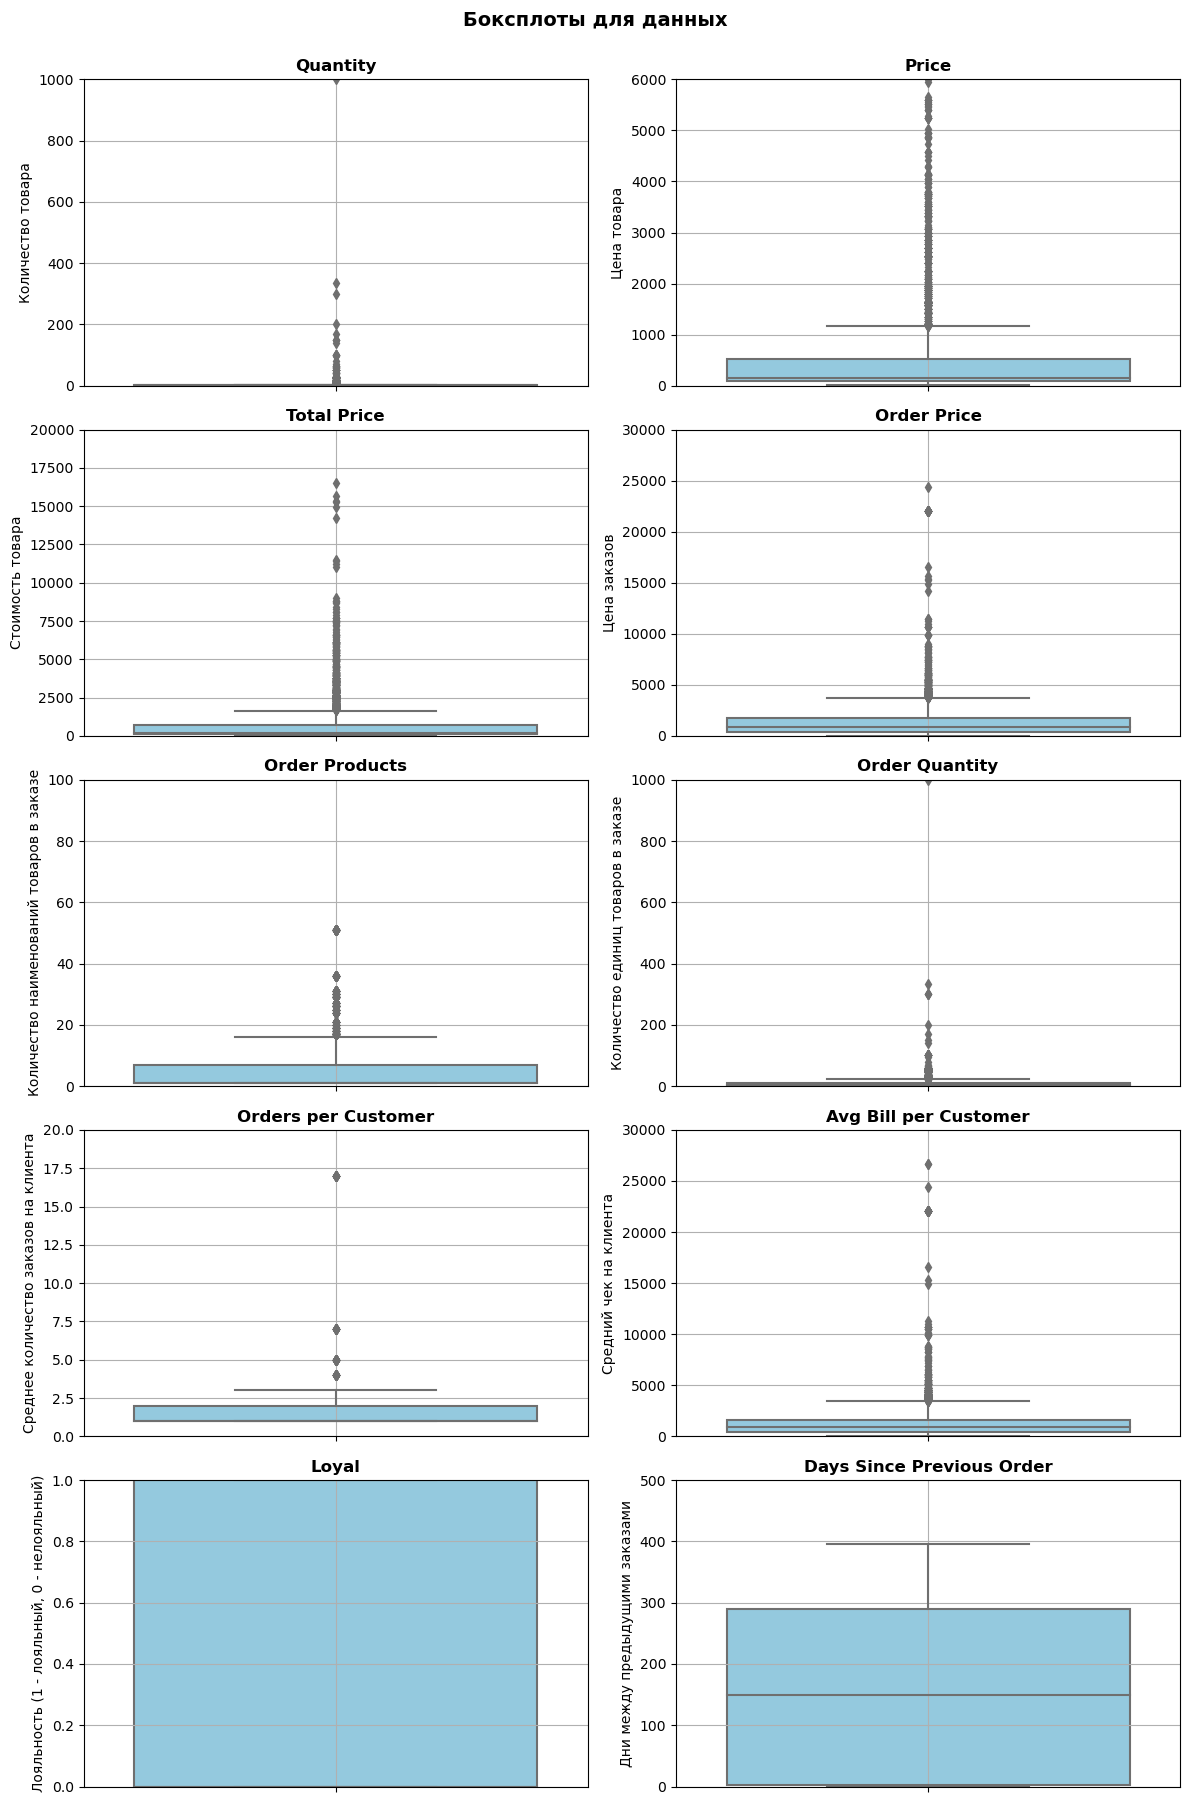

In [130]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))

columns = [
    ('quantity', 'Quantity', 'Количество товара', (0, 1000)),  # Устанавливаем лимиты по оси Y
    ('price', 'Price', 'Цена товара', (0, 6000)),  # Устанавливаем лимиты по оси Y
    ('total_price', 'Total Price', 'Стоимость товара', (0, 20000)),  # Устанавливаем лимиты по оси Y
    ('order_price', 'Order Price', 'Цена заказов', (0, 30000)),  # Устанавливаем лимиты по оси Y
    ('order_products', 'Order Products', 'Количество наименований товаров в заказе', (0, 100)),
    ('order_quantity', 'Order Quantity', 'Количество единиц товаров в заказе', (0, 1000)),  # Устанавливаем лимиты по оси Y
    ('orders_per_customer', 'Orders per Customer', 'Среднее количество заказов на клиента', (0, 20)),  # Устанавливаем лимиты по оси Y
    ('avg_bill_per_customer', 'Avg Bill per Customer', 'Средний чек на клиента', (0, 30000)),  # Устанавливаем лимиты по оси Y
    ('loyal', 'Loyal', 'Лояльность (1 - лояльный, 0 - нелояльный)', (0, 1)),  # Устанавливаем лимиты по оси Y
    ('days_since_previous_order', 'Days Since Previous Order', 'Дни между предыдущими заказами', (0, 500))  # Устанавливаем лимиты по оси Y
]

# Цикл для построения боксплотов
for i, (column, title, description, ylim) in enumerate(columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.boxplot(data=df_filtered, y=column, ax=ax, color='skyblue')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(description, fontsize=10)
    ax.set_ylim(ylim)  # Устанавливаем лимиты по оси Y для данного графика
    ax.grid(True)
    
fig.suptitle('Боксплоты для данных', fontsize=14, fontweight='bold', y=1)

plt.tight_layout()

plt.show()

Данные содержат много выбросов, поэтому выберем только 2 переменные и посмотрим еще раз выбросы по ним

In [131]:
print('90, 95 и 99 перцентили стоимости товара', np.percentile(df_filtered['order_price'], [90, 95, 99]))

90, 95 и 99 перцентили стоимости товара [2922.   4129.25 8758.  ]


In [132]:
print('90, 95 и 99 перцентили количества товара', np.percentile(df_filtered['quantity'], [90, 95, 99]))

90, 95 и 99 перцентили количества товара [ 3.    6.   26.47]


In [133]:
df_filtered.query('quantity > 26')

,date,customer_id,order_id,product,quantity,price,total_price,order_price,order_quantity,order_products,date_ymd,month,year,year_month,orders_per_customer,avg_bill_per_customer,loyal,days_since_previous_order,category
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38.0,3648.0,3648.0,96,1,2018-10-01,10,2018,2018-10,1,3648.000000,0,NaN,care_clothes_shoes
127,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,набор вешалок для костюма 45см 4шт цвет: кремо...,37,202.0,7474.0,7474.0,37,1,2018-10-08,10,2018,2018-10,1,7474.000000,0,NaN,care_clothes_shoes
139,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"стяжка оконная с болтом ст-55 цинк, 1108354",64,19.0,1216.0,1216.0,64,1,2018-10-09,10,2018,2018-10,126,1265.936508,1,1.0,repairs
210,2018-10-12 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68623,"петля приварная гаражная d 14х90 мм с шаром, 1...",50,38.0,1900.0,1900.0,50,1,2018-10-12,10,2018,2018-10,35,1636.514286,1,0.0,repairs
241,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2850.0,8550.0,300,2,2018-10-16,10,2018,2018-10,1,8550.000000,0,NaN,repairs
242,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,5700.0,8550.0,300,2,2018-10-16,10,2018,2018-10,1,8550.000000,0,NaN,repairs
252,2018-10-16 22:00:00,42c5db22-6046-455b-a728-ff163a1b7808,68667,муляж красное яблоко мини полиуретан d-6 см,30,19.0,570.0,570.0,30,1,2018-10-16,10,2018,2018-10,1,570.000000,0,NaN,interior
254,2018-10-17 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,щетка для посуды *мила* sv3182 1807009,50,27.0,1350.0,3550.0,100,2,2018-10-17,10,2018,2018-10,35,1636.514286,1,1.0,cleaning
255,2018-10-17 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,"щетка-утюжок с ручкой миди, standart, york, g1126",50,44.0,2200.0,3550.0,100,2,2018-10-17,10,2018,2018-10,35,1636.514286,1,1.0,cleaning
480,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,8670.0,8670.0,170,1,2018-11-01,11,2018,2018-11,1,8670.000000,0,NaN,interior


Кажется, что это оптовые клиенты, не будем их удалять

In [134]:
df_filtered.query('order_price > 30000')

,date,customer_id,order_id,product,quantity,price,total_price,order_price,order_quantity,order_products,date_ymd,month,year,year_month,orders_per_customer,avg_bill_per_customer,loyal,days_since_previous_order,category
892,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,кухонные ножницы webber из нержавеющей стали с...,2,127.0,254.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_coocking
893,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457.0,29248.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_serv
894,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для мяса с пластмассовой ручкой 3...,6,127.0,762.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_serv
895,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для овощей с деревянной ручкой 31...,3,142.0,426.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_serv
896,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный универсальный с пластмассовой руч...,24,119.0,2856.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_serv
897,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,рыбочистка с деревянной ручкой с ножом 1518024,2,67.0,134.0,33680.0,101,6,2018-11-29,11,2018,2018-11,1,33680.0,0,NaN,dishes_serv
1127,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,тележка багажная delta тбр-22 синий грузоподъе...,57,574.0,32718.0,32718.0,57,1,2018-12-21,12,2018,2018-12,1,32718.0,0,NaN,trolleys_bags
1288,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,простынь вафельная 200х180 см wellness rw180-0...,27,1755.0,47385.0,47385.0,27,1,2019-01-15,1,2019,2019-01,2,26616.0,1,5.0,textile
3714,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0,49432.0,334,1,2019-06-11,6,2019,2019-06,1,49432.0,0,NaN,care_clothes_shoes
3782,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,675000.0,675000.0,1000,1,2019-06-18,6,2019,2019-06,1,675000.0,0,NaN,cleaning


Кажется, что можно удалить заказ 69156, так как клиент закупил только ножи и сделал всего один заказ. можно удалить заказ 71668, где 334 шт закуплено вешалок. А также заказ 69504, где куплено 57 тележек.

In [135]:
df_final = df_filtered.query('(order_id != 71743) & (order_id!= 71668) & (order_id!= 69504)')

In [136]:
len(df_final)

5551

In [137]:
percent_removed = ((len(df_filtered) - len(df_final)) / len(df_filtered)) * 100
print(f"Процент удаленных строк: {percent_removed:.2f}%")

Процент удаленных строк: 0.05%


### Проверка тренда сезонности

In [138]:
grouped_data = df_final.groupby('year_month')['order_id'].nunique().reset_index()
grouped_data['year_month'] = grouped_data['year_month'].astype(str)
grouped_data.columns = ['date', 'orders']



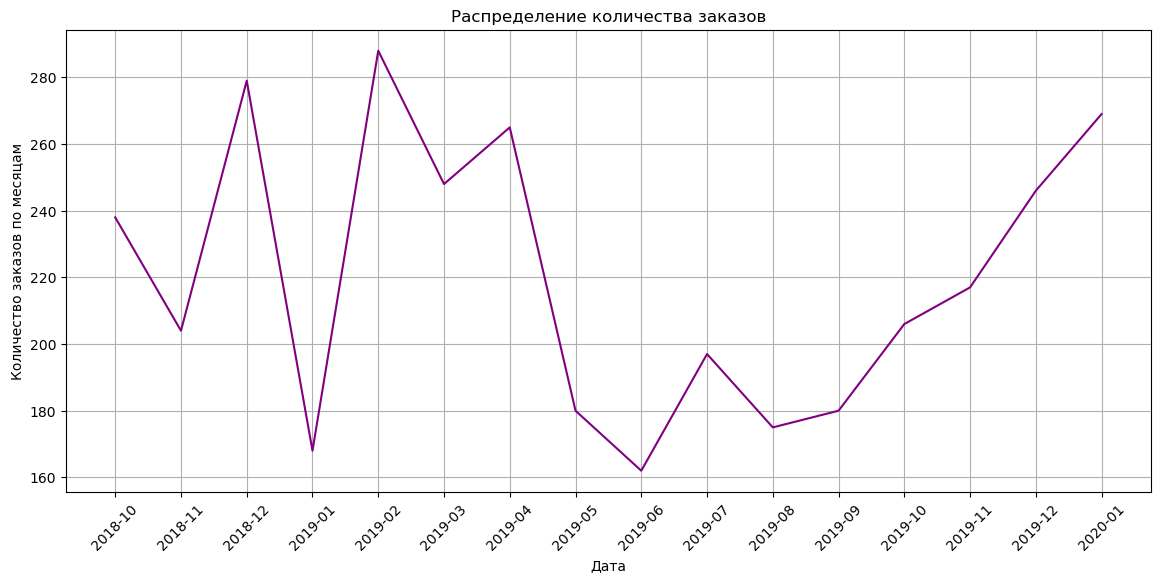

In [139]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='orders', color='purple', data=grouped_data)
plt.title('Распределение количества заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов по месяцам')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

**Выводы:**
- У магазина наблюдается положительная динамика по количеству заказов
- Весна-дачный сезон - пик активности. Также и период с сентября по январь

### Анализ категорий

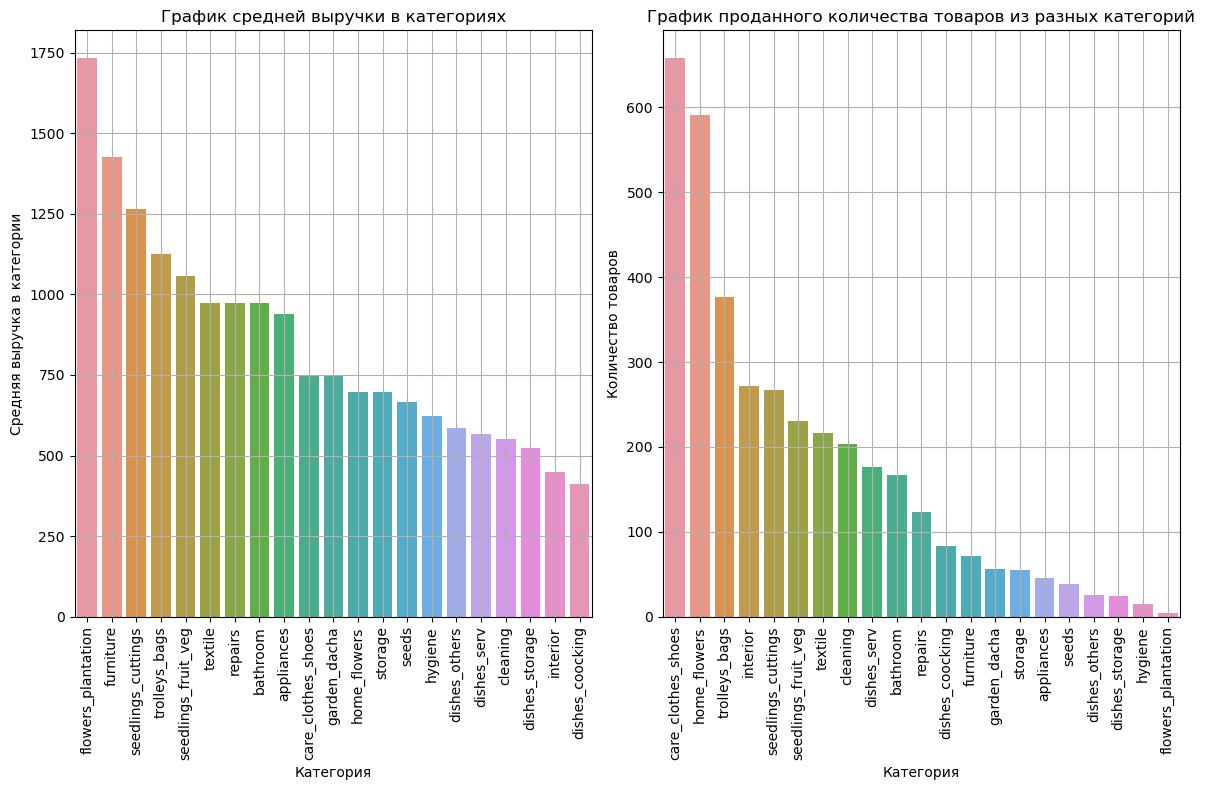

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# График медианной цены товаров
grouped_data3 = df_final.groupby('category').agg({'order_price': 'median', 'order_id': 'nunique'}).sort_values(by='order_price', ascending=False).reset_index()
grouped_data3.columns = ['category', 'revenue', 'orders']
sns.barplot(x='category', y='revenue', data=grouped_data3, ax=axes[0])
axes[0].set_title('График средней выручки в категориях')
axes[0].set_xlabel('Категория')
axes[0].set_ylabel('Средняя выручка в категории')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)

# График по количеству товаров
sns.barplot(x='category', y='orders', data=grouped_data3.sort_values(by='orders', ascending=False), ax=axes[1])
axes[1].set_title('График проданного количества товаров из разных категорий')
axes[1].set_xlabel('Категория')
axes[1].set_ylabel('Количество товаров')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)

# Выводим графики
plt.tight_layout()
plt.show()


In [141]:
df_final.query('category=="flowers_plantation"')

,date,customer_id,order_id,product,quantity,price,total_price,order_price,order_quantity,order_products,date_ymd,month,year,year_month,orders_per_customer,avg_bill_per_customer,loyal,days_since_previous_order,category
1289,2019-01-15 21:00:00,aa38e2e1-6da6-4f43-aa13-ed0210ea321c,69835,роза кустовая ред лейс 60 см кения плантация w...,25,112.0,2800.0,2800.0,25,1,2019-01-15,1,2019,2019-01,1,2800.0,0,NaN,flowers_plantation
1313,2019-01-19 23:00:00,4716c955-db54-4a8d-966a-a2190bdbd426,69883,роза одноголовая родос 70 см кения плантация s...,5,44.0,220.0,220.0,5,1,2019-01-19,1,2019,2019-01,1,220.0,0,NaN,flowers_plantation
1854,2019-03-04 16:00:00,e8420324-aacf-4aaf-8843-e2d8a33f2a88,70588,роза одноголовая свит юник 70 см эквадор плант...,9,74.0,666.0,666.0,9,1,2019-03-04,3,2019,2019-03,1,666.0,0,NaN,flowers_plantation
3424,2019-05-26 09:00:00,8a832dff-d6f8-4053-8f7b-91dd69e27a3c,71514,роза одноголовая тоффи 70 см эквадор плантация...,25,157.0,3925.0,3925.0,25,1,2019-05-26,5,2019,2019-05,1,3925.0,0,NaN,flowers_plantation


**Выводы:**
- Лучше всего с точки зрения того, сколько тратят клиенты, категории: цветы с плантации (возможно, из-за того, что это оптовые закупки). Мебель - из-за цены товаров, рассада цветов и черенки, тележки, рассада овощей и фруктов из-за количества заказов.
- Много заказов товаров по уходу за одеждой и обувью, домашних цветов и сумок и тележек.
- Средняя выручка в продаже рассады растений и черенков тоже хорошая, как и тележек и рассады овощей/фруктов и текстиля.

## Кластеризация

Для начала сгруппируем данные по customer_id. Для кластеризации будем использовать средние значения по переменным.

In [142]:
df_clusters = df_final.groupby('customer_id').agg({'quantity':'mean', 'order_products':'mean',
                                                 'price':'mean', 'order_price':'mean', 
                                                   'orders_per_customer':'mean', 'avg_bill_per_customer':'mean'}).reset_index()
df_clusters.columns = ['customer_id', 'quantity_avg', 'products_in_order_avg', 'item_price_avg',
              'order_price_avg', 'orders_cnt_per_customer', 'avg_bill']
df_clusters

,customer_id,quantity_avg,products_in_order_avg,item_price_avg,order_price_avg,orders_cnt_per_customer,avg_bill
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1.0,4.0,138.75,555.0,1.0,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,1.0,442.00,442.0,1.0,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,1.0,457.00,914.0,1.0,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1.0,1649.00,1649.0,1.0,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,1.0,1162.00,2324.0,1.0,2324.0
...,...,...,...,...,...,...,...
2422,ff601403-b094-4b86-9ac6-264d725b9277,1.0,1.0,869.50,869.5,2.0,869.5
2423,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1.0,1.0,397.00,397.0,1.0,397.0
2424,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1.0,1.0,389.00,389.0,1.0,389.0
2425,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1.0,1.0,974.00,974.0,1.0,974.0


In [143]:
df_clusters = pd.DataFrame(df_clusters)

Для начала отберем признаки, которые будут участвовать в кластеризации, посмотрим еще раз корреляцию

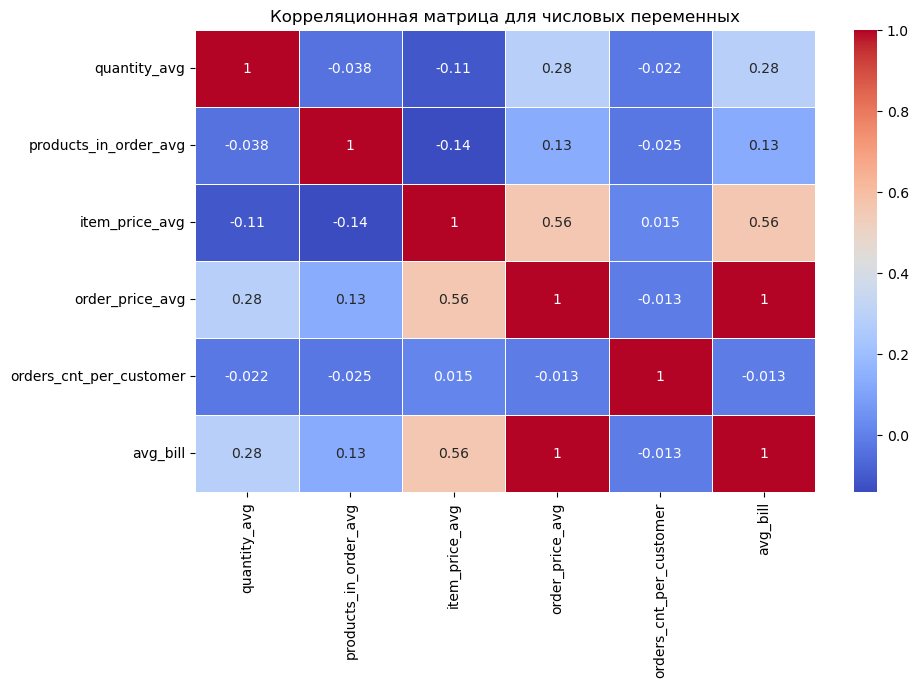

In [144]:
corr_matrix = df_clusters.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Корреляционная матрица для числовых переменных')
plt.show()

Таким образом удалим avg_bill 

In [145]:
X = df_clusters[['quantity_avg', 'products_in_order_avg', 'item_price_avg',
              'order_price_avg']]

Выполним стандартизацию

In [146]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Выполним 2 алгоритма кластеризации: 
- иерархическую кластеризацию, чтобы примерно определить количество кластеров
- алгоритм k-means с указанием количества кластеров, полученных на предыдущем шаге

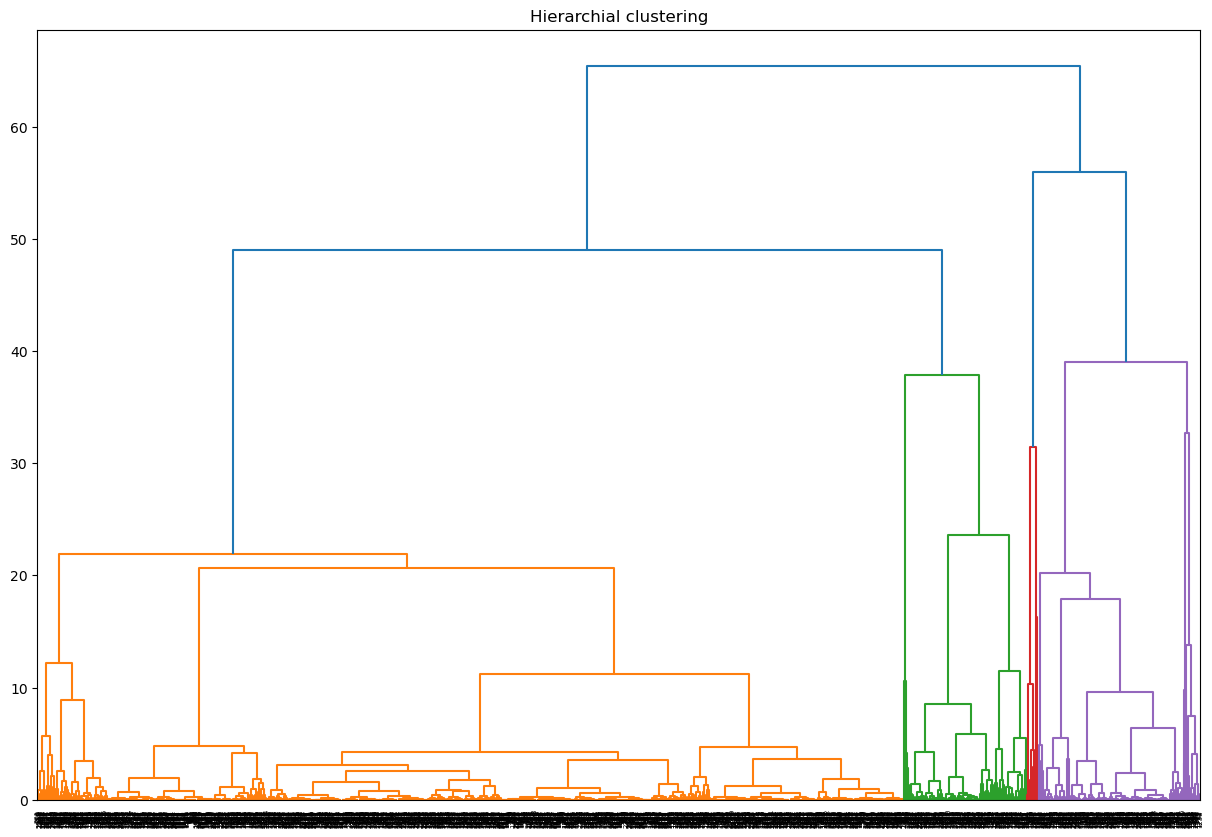

In [147]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Четко выделяются 4 кластера.

In [148]:
km = KMeans(n_clusters=4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df_clusters['cluster_km'] = labels

In [149]:
df_clusters['cluster_km'].value_counts()

0    2124
1     202
2      89
3      12
Name: cluster_km, dtype: int64

Самый многочисленный кластер по количеству клиентов - 0 и он существенно отличается от других

### Анализ кластеров по средним значениям

Сначала проанализируем среднием значения по кластерам

In [150]:
df_clusters.groupby('cluster_km').mean()

,quantity_avg,products_in_order_avg,item_price_avg,order_price_avg,orders_cnt_per_customer,avg_bill
cluster_km,,,,,,
0,2.655165,1.318761,500.789803,755.529133,1.472693,753.970949
1,2.350248,1.126238,3257.464934,4539.050330,1.371287,4543.939769
2,1.333981,13.641045,127.521730,1977.520938,1.146067,1959.015356
3,140.500000,1.083333,37.041667,5760.666667,1.000000,5760.666667


- Кластер 0:

Среднее количество купленных единиц товара (quantity_avg) находится в среднем диапазоне, что может указывать на обычных потребителей.
Средний чек (avg_bill) и средняя стоимость заказа (order_price_avg) также находятся на среднем уровне, что может говорить о сбалансированном соотношении между количеством и стоимостью покупок. Клиенты этого кластера могут быть типичными розничными покупателями.

- Кластер 1:

Этот кластер характеризуется самой высокой средней стоимостью заказа (order_price_avg) и самым высоким средним чеком (avg_bill). Это может указывать на приверженность высокой ценовой категории товаров, на клиентов, готовых совершать дорогие покупки.

- Кластер 2:

Среднее количество наименований в заказе (products_in_order_avg) в этом кластере сильно выделяется и составляет более 13, что может указывать на то, что клиенты из этого кластера совершают большие оптовые закупки с большим ассортиментом товаров. Средняя цена товара (item_price_avg) низкая, но средняя стоимость заказа (order_price_avg) всё равно остается на уровне, который говорит о значительных объемах заказов.

- Кластер 3:

Этот кластер сильно выделяется средним количеством купленных единиц товара (quantity_avg) - в среднем покупают 140.5 единиц товаров, что гораздо больше, чем в других кластерах. Это может указывать на специфический тип клиентов, которые покупают товары в больших количествах, возможно, для перепродажи или других бизнес-целей (оптовые покупатели). Средняя цена товара (item_price_avg) в этом кластере низкая, но средняя стоимость заказа (order_price_avg) очень высокая, что также может указывать на оптовые закупки.

Теперь объединим df_clusters и df_final

In [151]:
cluster_km = df_clusters[['customer_id', 'cluster_km']].reset_index(drop=True)
df_final = df_final.merge(cluster_km, on='customer_id', how='left')

Анализ категорий по кластерам

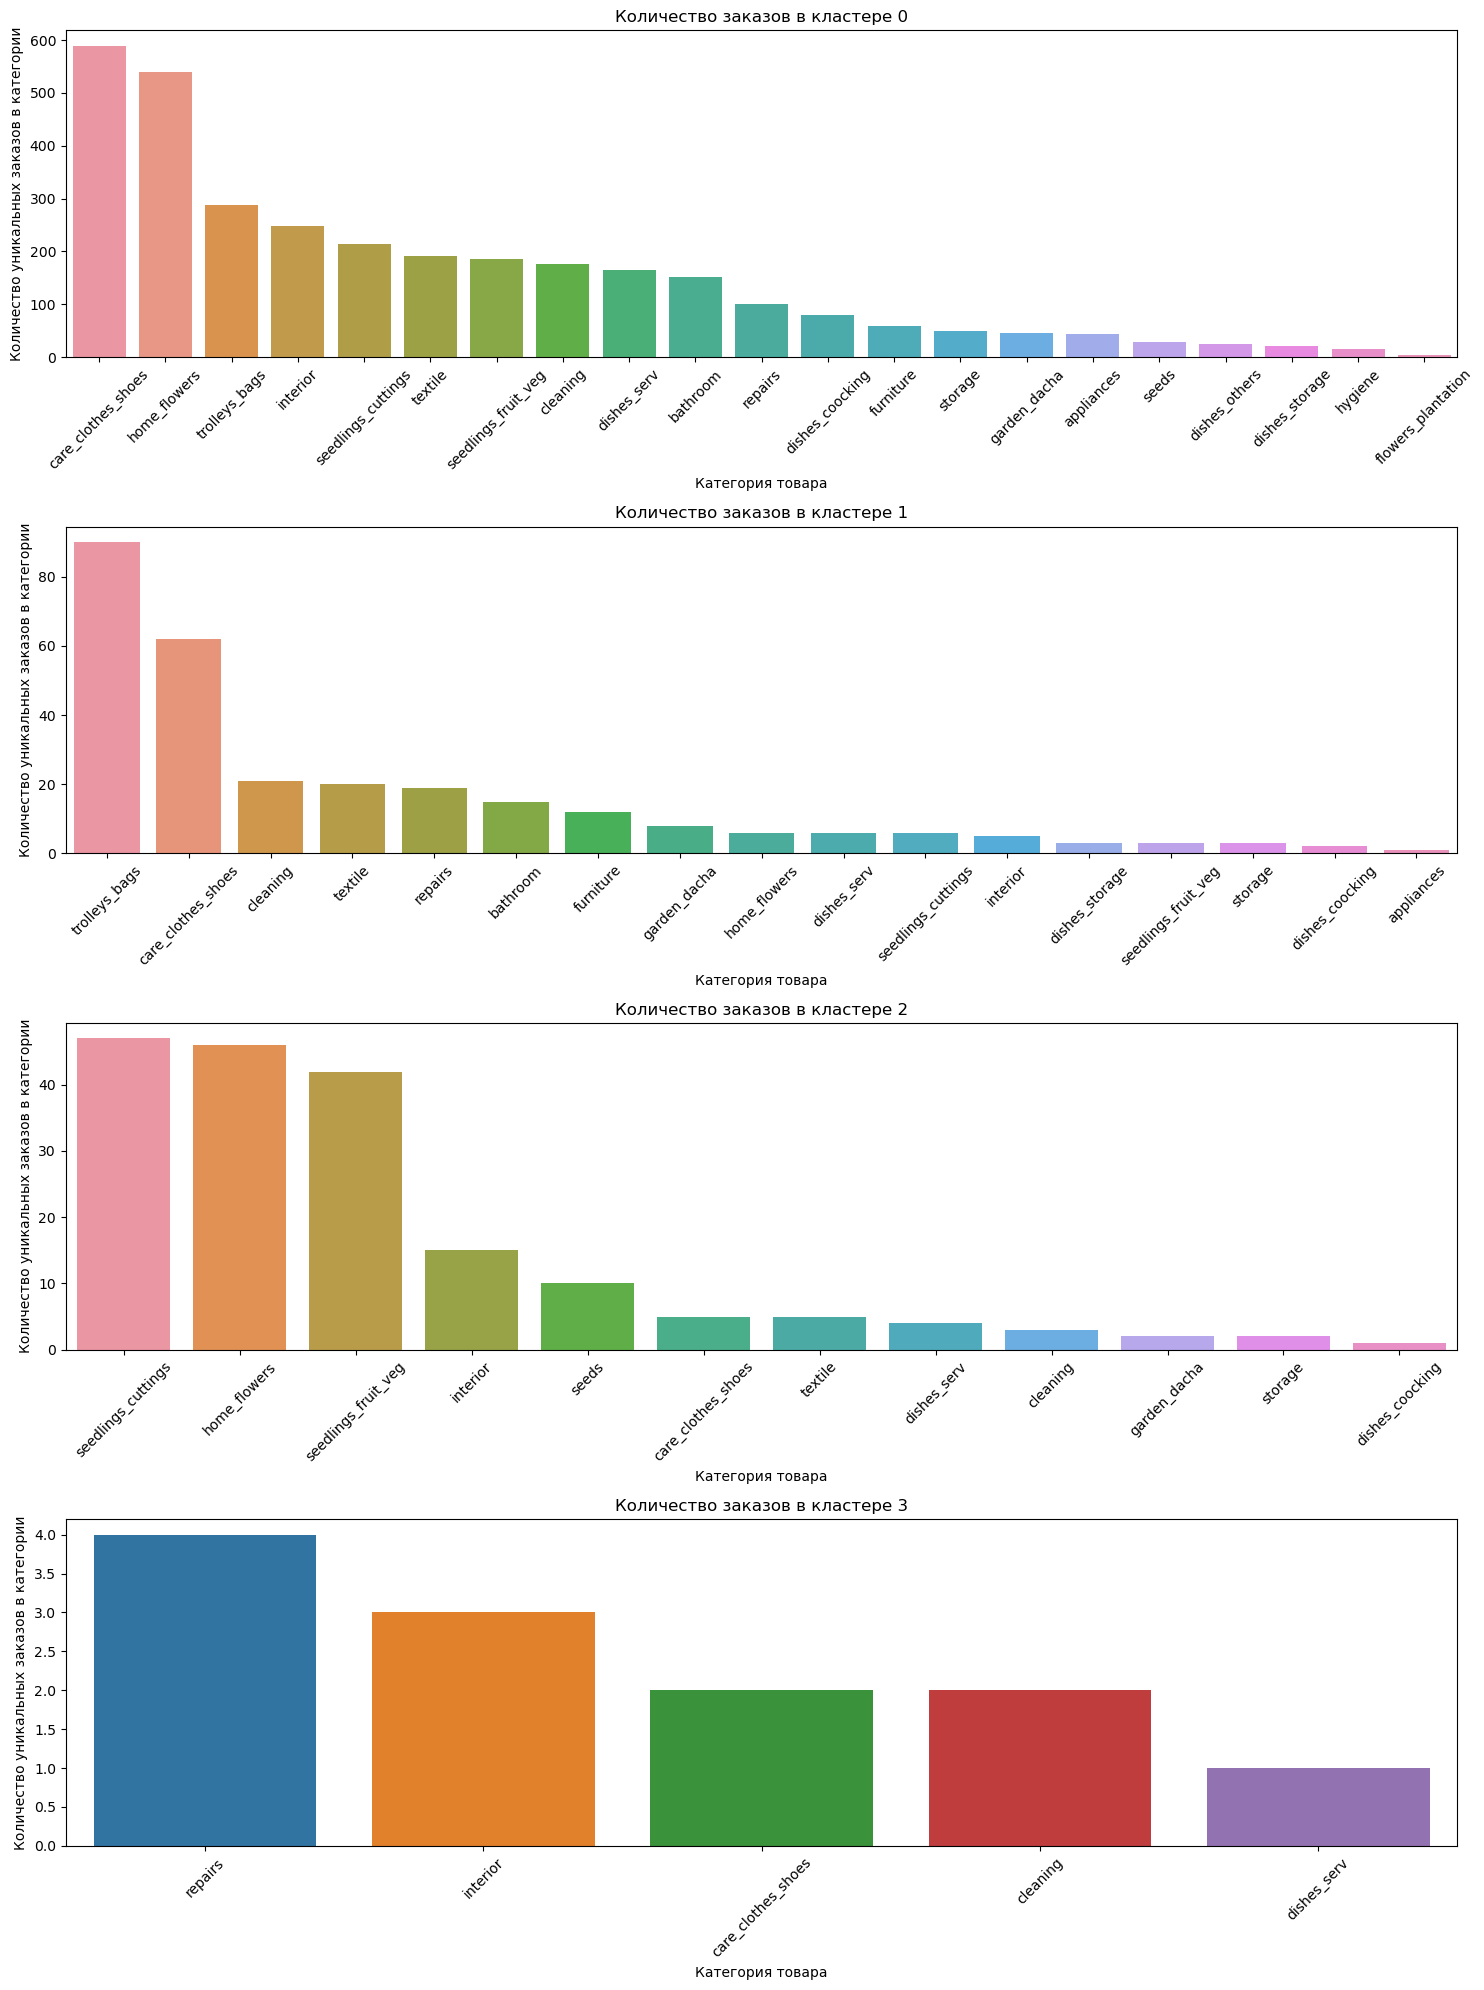

In [152]:
clusters = [0,1,2,3]

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

# Преобразуем матрицу axes в одномерный массив для удобства
axes = axes.ravel()

for i, cluster in enumerate(clusters):
    # Создаем сводную таблицу для текущего кластера и сбрасываем индекс
    cluster_data0 = df_final[df_final['cluster_km'] == cluster].pivot_table(
        index='category',
        values='order_id',
        aggfunc={'order_id': 'nunique'}  # Используем 'nunique' для подсчета уникальных заказов
    ).reset_index()

    # Создаем график в текущей ячейке сетки
    sns.barplot(x='category', y='order_id', data=cluster_data0.sort_values(by='order_id', ascending=False), ax=axes[i])
    axes[i].set_xlabel('Категория товара')
    axes[i].set_ylabel('Количество уникальных заказов в категории')
    axes[i].set_title(f'Количество заказов в кластере {cluster}')
    axes[i].tick_params(axis='x', rotation=45)

# Добавляем между графиками некоторое расстояние
plt.tight_layout()
plt.show()

**Выводы:**

- В 0 кластере больше всего заказов в категории домашних цветов и товаров по уходу за одеждой и обувью.
- В 1 кластере наоборот покупают больше всего товары по уходу за одеждой и обувью
- Во 2 кластере преобладают покупки в категории интерьера и рассады овощей и фруктов
- В 3 кластере мало заказов из категорий ремонт, интерьер, товары по уходу за одеждой и обувью

### Проверка статистических гипотез

Теперь проверим, действительно ли есть статически значимые различия в наших кластерах

#### Гипотеза о средней стоимости заказа

Сформулируем гипотезы:
- H0: Нет статистически значимых различий в средней стоимости заказа
- H1: Существуют статистически значимые различия в средней стоимости заказа

Так как проверка гипотез множественная, сделаем корректировку уровня альфа методом Холма.

In [153]:
# Корректировка уровня альфа методом Холма

order = {}

for cluster, data in df_clusters.groupby('cluster_km'):
    order[cluster] = data['order_price_avg']

cluster_combinations = list(itertools.combinations(order.keys(), 2))
alpha = 0.05

p_values = []

for cluster1, cluster2 in cluster_combinations:
    data1 = order[cluster1]
    data2 = order[cluster2]
    
    statistic, p_value = st.mannwhitneyu(data1, data2)
    p_values.append(p_value)

# Применяем метод коррекции Холма
reject, p_values_corrected, _, _ = multipletests(p_values, method='holm')

for i, (cluster1, cluster2) in enumerate(cluster_combinations):
    print(f'Сравнение кластера {cluster1} и кластера {cluster2} по столбцу "order_price_avg":')
    print(f'Значение p-значения = {p_values_corrected[i]}')
    
    if p_values_corrected[i] < alpha:
        print('Существуют статистически значимые различия в средней стоимости заказа между кластерами.\n')
    else:
        print('Нет статистически значимых различий в средней стоимости заказа между кластерами.\n')


Сравнение кластера 0 и кластера 1 по столбцу "order_price_avg":
Значение p-значения = 1.5293915248041043e-115
Существуют статистически значимые различия в средней стоимости заказа между кластерами.

Сравнение кластера 0 и кластера 2 по столбцу "order_price_avg":
Значение p-значения = 9.849418669211882e-29
Существуют статистически значимые различия в средней стоимости заказа между кластерами.

Сравнение кластера 0 и кластера 3 по столбцу "order_price_avg":
Значение p-значения = 1.4881164879689917e-08
Существуют статистически значимые различия в средней стоимости заказа между кластерами.

Сравнение кластера 1 и кластера 2 по столбцу "order_price_avg":
Значение p-значения = 9.849418669211882e-29
Существуют статистически значимые различия в средней стоимости заказа между кластерами.

Сравнение кластера 1 и кластера 3 по столбцу "order_price_avg":
Значение p-значения = 0.16620233644921367
Нет статистически значимых различий в средней стоимости заказа между кластерами.

Сравнение кластера 2 

Вывод: все кластеры статистически значимо отличаются по средней стоимости заказов, кроме 1 и 3.

#### Гипотеза о количестве единиц товаров

Сформулируем гипотезы:
- H0: Нет статистически значимых различий в среднем количестве единиц товара, купленных одним покупателем, между кластерами
- H1: Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем между кластерами

In [154]:
quantity = {}
for cluster, data in df_clusters.groupby('cluster_km'):
    quantity[cluster] = data['quantity_avg']

cluster_combinations = list(itertools.combinations(order.keys(), 2))
alpha_corrected = 0.05

p_values = []


for cluster1, cluster2 in cluster_combinations:
    data1 = quantity[cluster1]
    data2 = quantity[cluster2]
    
    statistic, p_value = st.mannwhitneyu(data1, data2)
    p_values.append(p_value)
    
# Применяем метод коррекции Холма
reject, p_values_corrected, _, _ = multipletests(p_values, method='holm') 

for i, (cluster1, cluster2) in enumerate(cluster_combinations):
    print(f'Сравнение кластера {cluster1} и кластера {cluster2} по столбцу "quantity_avg":')
    print(f'Значение p-значения = {p_values_corrected[i]}')
    
    if p_values_corrected[i] < alpha:
        print('Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем, между кластерами.\n')
    else:
        print('Нет статистически значимых различий в среднем количестве единиц товара, купленных одним покупателем, между кластерами.\n')


Сравнение кластера 0 и кластера 1 по столбцу "quantity_avg":
Значение p-значения = 0.004172914965038193
Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем, между кластерами.

Сравнение кластера 0 и кластера 2 по столбцу "quantity_avg":
Значение p-значения = 0.0030777769757444826
Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем, между кластерами.

Сравнение кластера 0 и кластера 3 по столбцу "quantity_avg":
Значение p-значения = 9.543525837337755e-13
Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем, между кластерами.

Сравнение кластера 1 и кластера 2 по столбцу "quantity_avg":
Значение p-значения = 1.948110913882528e-06
Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем, между кластерами.

Сравнение кластера 1 и кластера 3 по столбцу "quantity_avg":
Значение p-з

Вывод: статистически значимо по среднему количеству купленных единиц товара клиентом отличаются все кластеры. Отвергаем нулевую гипотезу.

### Сезонность в кластерах

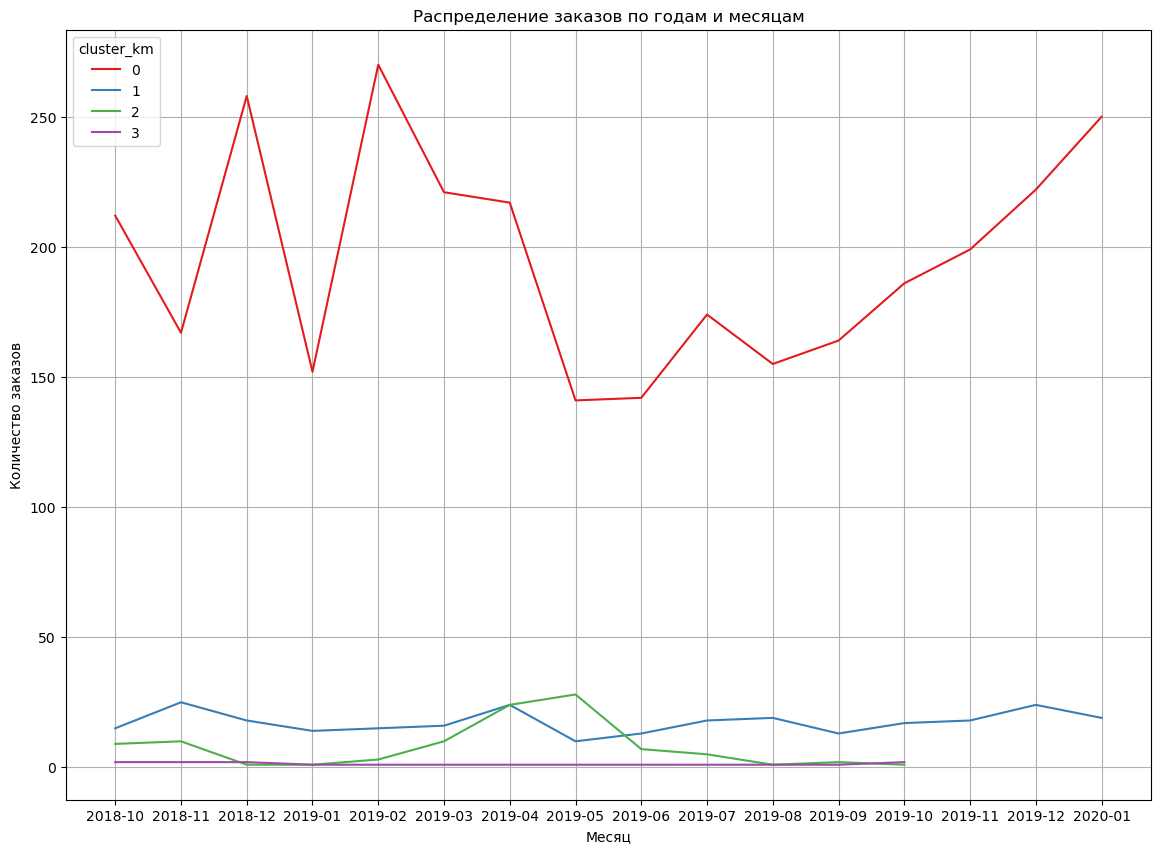

In [155]:
monthly_order_counts = df_final.groupby(['year_month', 'cluster_km'])['order_id'].nunique().reset_index()
monthly_order_counts['year_month'] = monthly_order_counts['year_month'].astype(str)  # Преобразование в строковый формат

plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='cluster_km', data=monthly_order_counts, palette='Set1')

plt.title('Распределение заказов по годам и месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.grid(True)
plt.show()

- График показывает, что самые активные покупатели по количеству заказов в 0 кластере и это основная аудитория магазина, которая делает заказы. Заказывают под конец года активно.
- Также видно, что покупатели из 2 и 3 кластера перестали делать заказы с ноября 2019 года.
- Количество заказов было максимальным в январе 2019 года.

### Сезонность для топ-10 категорий

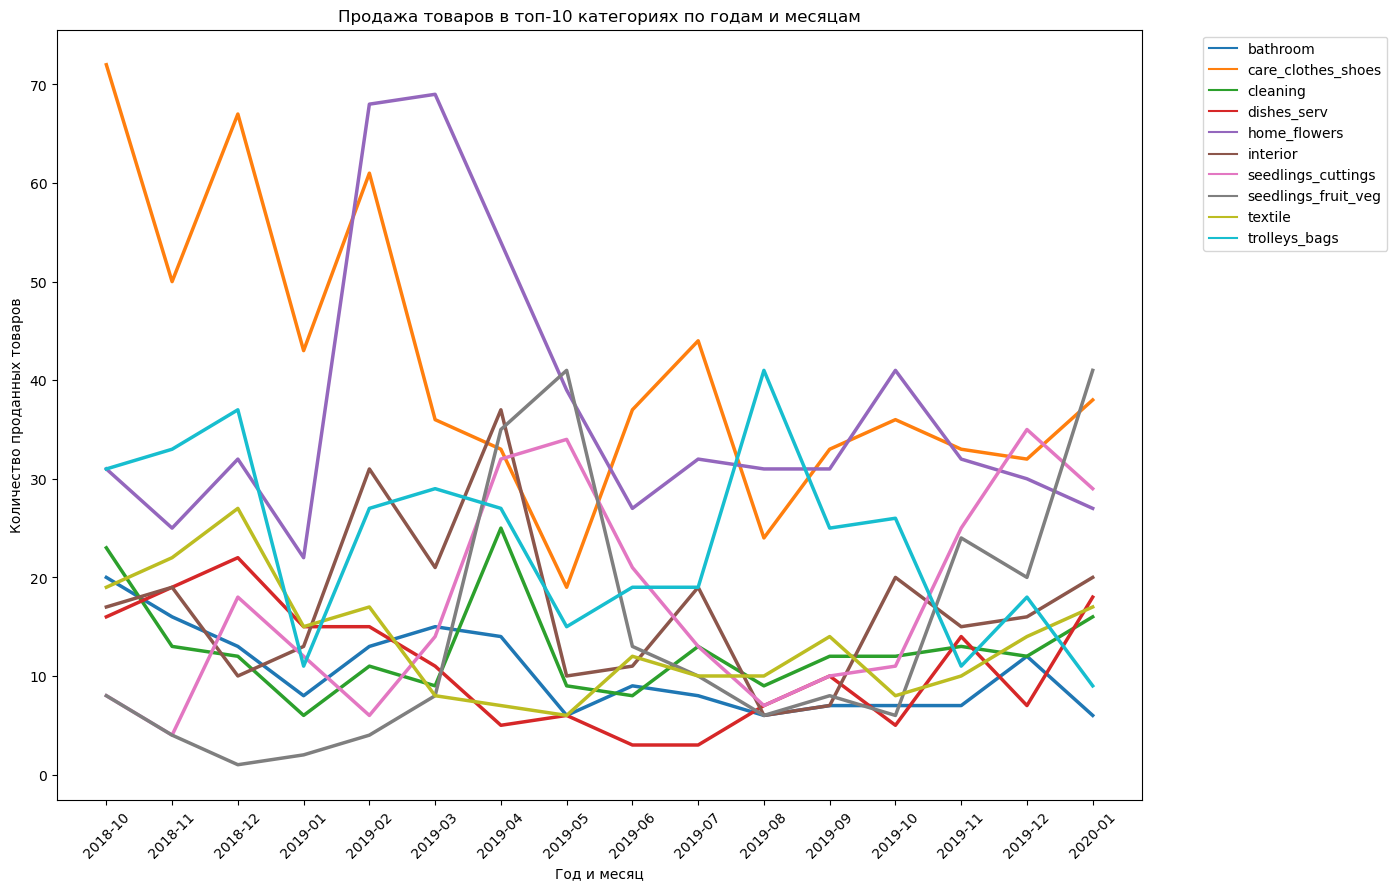

In [156]:
top10_categories = df_final.groupby('category')['order_id'].nunique().sort_values(ascending=False).head(10).reset_index()
top10_categories = df_final[df_final['category'].isin(top10_categories['category'])].groupby(['year_month','category'])['order_id'].nunique().reset_index()

# Преобразование столбца 'year_month' в строковый формат
top10_categories['year_month'] = top10_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='category', data=top10_categories, palette='tab10', linewidth=2.5)
plt.title('Продажа товаров в топ-10 категориях по годам и месяцам')
plt.xlabel('Год и месяц')
plt.ylabel('Количество проданных товаров')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- Категория домашних цветом пользовалась популярностью с января 2019 года по июнь 2019 года, далге продажи были на среднем уровне
- Категория товаров по уходу за одеждой тоже бОльшей пользовалась популярностью в октябре 2018 года, а потом продажи тоже стали средними, но стабильными
- Продажи категории товаров "сумки и тележки" распределены неравномерно: пики в декабре 2018 года и в августе 2019, дальше спад (возможно это какие-то крупные оптовые закупки)
- Рассада и черенки: присутствует сезонный фактор - рост продаж в марте-мае 2019 года (сезон посадок) и в декабре 2019 года (возможно завезли новогодние деревья, а в конце 2018 их не было)
- Рассада овощей, фруктов и зелени: пики заказов в мае 2019 и январе 2020 (может начали готовиться уже к дачному сезону?)
- Рост заказов в категории товаров посуды для сервировки наблюдается 2 раза и оба - в декабре. Возможно это связано с сервировкой праздничного стола.
- Пик продаж в категории интерьер - в апреле 2019 года. В этой категории, в основном, муляжи и искусственные цветы.
- Продажи текстиля снизились к концу 2019 года по сравнению с 2018.
- Продажи товаров для ванны и уборки распредлены равномерно. Количество заказов товаров для уборки снизилось в 2019 году по сравнению с 2019.

In [157]:
df_final.loc[(df_final['category']=='seedlings_fruit_veg') & (df_final['year_month'] == '2020-01')]['product'].unique()

array(['томата (помидор) абруццо № 3 сорт индетерминантный среднеспелый красный',
       'рассада зелени для кухни мята икс пиперита цитрата грэйпфрут диам. 9 см',
       'томата (помидор) роджеро № 104 сорт индетерминантный среднеспелый красный',
       'рассада томата (помидор) сорт хурма, горшок диам 12',
       'клубника хоней p9 крым',
       'огурец багратион f1 пчелоопыляемый в кассете 4 штуки раннеспелый',
       'рассада капусты кольраби мадонна, кассета по 10шт',
       'рассада капусты белокачанная средняя подарок, кассета по 10шт',
       'иссоп лекарственный d-9 см',
       'томата (помидор) летнее солнце № 92 сорт индетерминантный раннеспелый желтый',
       'томата (помидор) исуповский №37 сорт индетерминантный среднеспелый красный',
       'рассада капусты белокачанная поздняя лидер, кассета по 10шт',
       'базилик овощной пурпурные звезды в кассете 4 штуки среднеспелый',
       'томата (помидор) примари колорз №67 сорт детерминантный среднеспелый черный',
       'баз

Действительно, некоторые клиенты уже в январе начали готовиться к дачному сезону, закупая рассаду

### Анализ  по категориям  и товарам для кластера 0

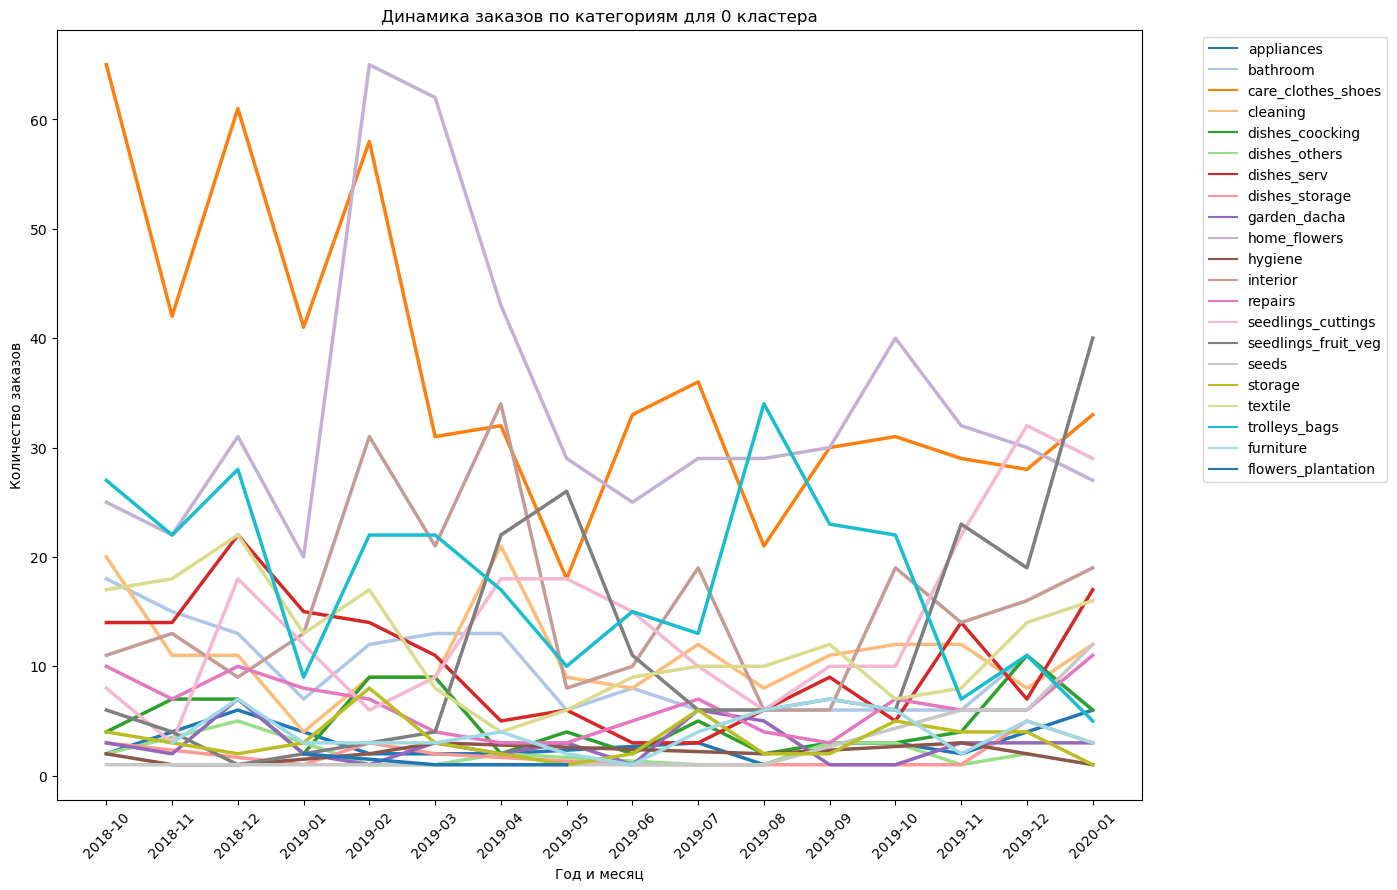

In [158]:
cluster0_categories = df_final.loc[df_final['cluster_km'] == 0].groupby(['year_month', 'category']).agg({'order_id':'nunique', 'order_price': 'sum'}).reset_index()

# Преобразование столбца 'year_month' в строковый формат
cluster0_categories['year_month'] = cluster0_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='category', data=cluster0_categories, palette='tab20', linewidth=2.5)
plt.title('Динамика заказов по категориям для 0 кластера')
plt.xlabel('Год и месяц')
plt.ylabel('Количество заказов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- В целом для данного кластера наблбдается положительная динамика с пиками в мае и январе для категории рассады овощей и фруктов (зелени)
- Категории товаров для дома и домашних цветов: динамика хорошая, пики для товаров для одежды в октябре 2018, феврале 2019, под конец 2019 рост. Домашние цветы: пик заказов в феврале-марте (под 8 марта закупки возможно)
  

Теперь рассмотрим товары из топа 5 категорий для данного кластера

In [159]:
cluster0_top_categories = df_final.loc[df_final['cluster_km'] == 0].groupby('category').agg({'order_id':'nunique', 'order_price': 'sum'}).sort_values(by=['order_id', 'order_price'], ascending=False).head(5).reset_index()
cluster0_top_categories

,category,order_id,order_price
0,care_clothes_shoes,589,602553.666667
1,home_flowers,539,502471.833333
2,trolleys_bags,287,385436.750000
3,interior,249,116745.333333
4,seedlings_cuttings,214,264931.500000


In [160]:
cluster0_top5_products = df_final[df_final['category'].\
                                  isin(cluster0_top_categories['category'])].groupby(['category', 'product']).\
                                  size().reset_index(name='count').\
                                  sort_values(by='count', ascending=False).head(30)

In [161]:
cluster0_top5_products

,category,product,count
459,home_flowers,пеларгония розебудная red pandora укорененный ...,66
457,home_flowers,пеларгония розебудная prins nikolai укорененны...,56
432,home_flowers,пеларгония зональная диам. 12 см сиреневый пол...,53
1009,trolleys_bags,сумка-тележка 2-х колесная gimi argo синяя,47
456,home_flowers,пеларгония розебудная mary укорененный черенок,40
455,home_flowers,пеларгония розебудная margaretha укорененный ч...,31
458,home_flowers,пеларгония розебудная queen ingrid укорененный...,31
446,home_flowers,пеларгония зональная ринго вайт d-7 см h-10 см...,25
440,home_flowers,пеларгония зональная махровая лососевая,25
413,home_flowers,пеларгония зональная диам. 12 см коралловая по...,24


В 0 кластере клиенты заказывают, в основном:
- Пеларгонии
- Сумки-тележки
- Петунии
- Сушилки для белья

In [162]:
unique_dates = set()
order_count_by_date = {}

# Фильтрация DataFrame для первого кластера
df_cluster0 = df_final[df_final['cluster_km'] == 0]

for index, row in df_cluster0.iterrows():
    product_name = row['product']
    if 'петуния' in product_name.lower():
        order_date = row['year_month']
        unique_dates.add(order_date)

for date in unique_dates:
    order_count_by_date[date] = 0

for index, row in df_cluster0.iterrows():
    product_name = row['product']
    if 'петуния' in product_name.lower():
        order_date = row['year_month']
        order_count_by_date[order_date] += 1

print("Количество заказов с 'петуния' по датам для 0 кластера:")
for date, count in order_count_by_date.items():
    print(f"Дата: {date}, Количество заказов: {count}")


Количество заказов с 'петуния' по датам для 0 кластера:
Дата: 2019-06, Количество заказов: 13
Дата: 2019-12, Количество заказов: 5
Дата: 2019-07, Количество заказов: 2
Дата: 2019-04, Количество заказов: 13
Дата: 2020-01, Количество заказов: 4
Дата: 2019-03, Количество заказов: 4
Дата: 2019-11, Количество заказов: 4
Дата: 2019-09, Количество заказов: 1
Дата: 2019-10, Количество заказов: 1
Дата: 2019-05, Количество заказов: 29


Пик продаж - апрель, май, август. Хуже всего продажи в сентябре и октябре

### Анализ по категориям и товарам для кластера 1

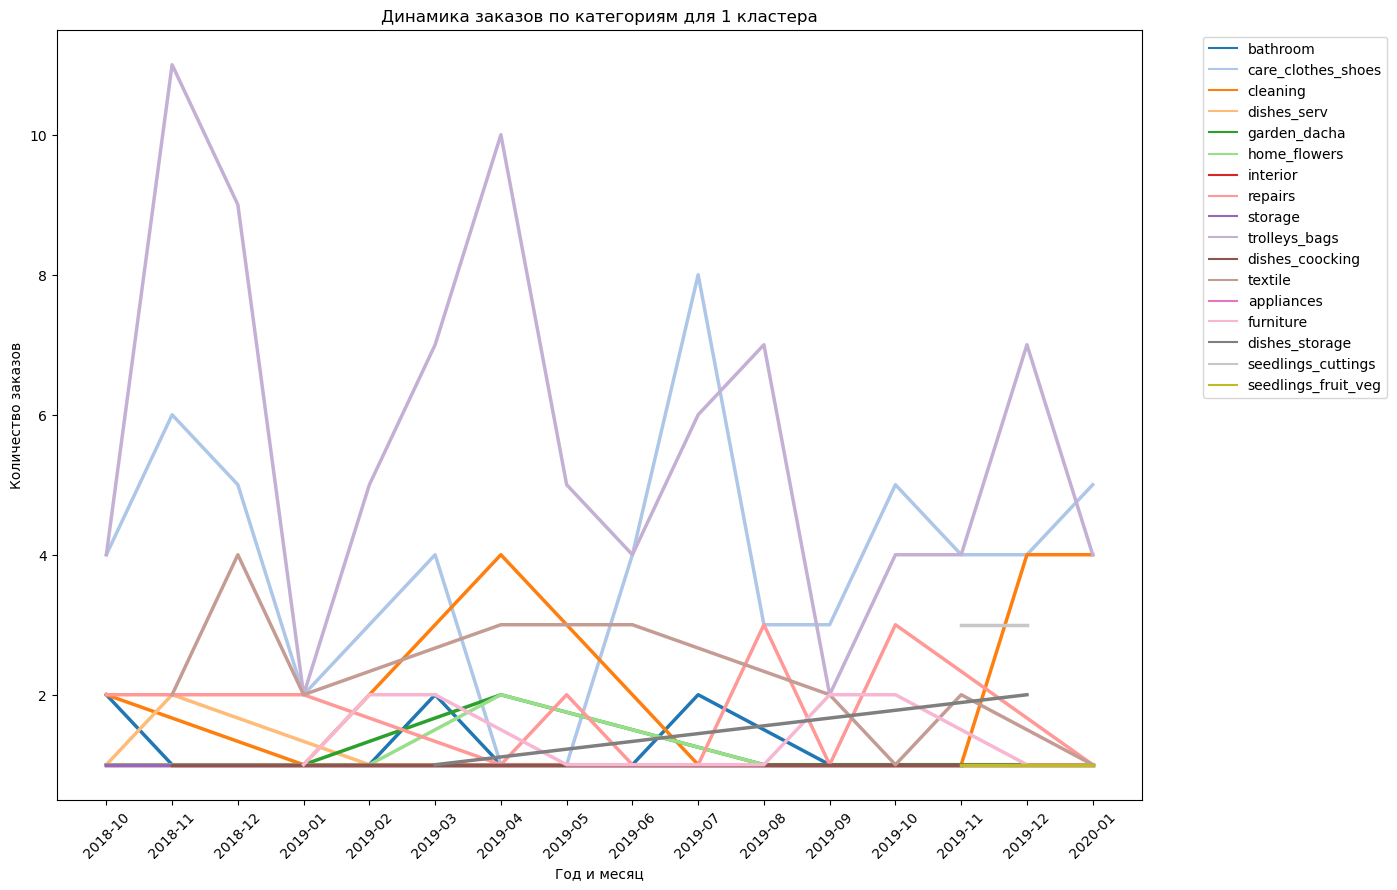

In [163]:
cluster1_categories = df_final.loc[df_final['cluster_km'] == 1].groupby(['year_month', 'category']).agg({'order_id':'nunique', 'order_price': 'sum'}).reset_index()

# Преобразование столбца 'year_month' в строковый формат
cluster1_categories['year_month'] = cluster1_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='category', data=cluster1_categories, palette='tab20', linewidth=2.5)
plt.title('Динамика заказов по категориям для 1 кластера')
plt.xlabel('Год и месяц')
plt.ylabel('Количество заказов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- Выделяются по количеству заказов категории сумок и тележек + товары по уходу за одеждой и обувью. Говорить о сезонности сложно, данные распределены по пикам.

In [164]:
cluster1_top_categories = df_final.loc[df_final['cluster_km'] == 1].groupby('category').agg({'order_id':'nunique', 'order_price': 'sum'}).sort_values(by=['order_id', 'order_price'], ascending=False).head(5).reset_index()
cluster1_top_categories

,category,order_id,order_price
0,trolleys_bags,90,438305.5
1,care_clothes_shoes,62,289036.5
2,cleaning,21,104444.0
3,textile,20,166623.0
4,repairs,19,75167.0


In [165]:
cluster1_top5_products = df_final[df_final['category'].\
                                  isin(cluster1_top_categories['category'])].groupby(['category', 'product']).\
                                  size().reset_index(name='count').\
                                  sort_values(by='count', ascending=False).head(30)
cluster1_top5_products

,category,product,count
682,trolleys_bags,сумка-тележка 2-х колесная gimi argo синяя,47
770,trolleys_bags,тележка багажная delta тбр-20 синий грузоподъе...,17
213,care_clothes_shoes,сушилка для белья настенная zalger prima 510-7...,17
769,trolleys_bags,тележка багажная delta тбр-20 коричневый с ора...,16
233,care_clothes_shoes,"сушилка для белья потолочная лиана 2,0 м 1703009",11
691,trolleys_bags,сумка-тележка 2-х колесная складная gimi flexi...,11
410,cleaning,"таз пластмассовый со стиральной доской (иж), 1...",10
235,care_clothes_shoes,"сушилка для белья потолочная лиана 2,4 м 1703011",10
768,trolleys_bags,тележка багажная delta тбр-15 цвет в ассортиме...,10
681,trolleys_bags,сумка-тележка 2-х колесная gimi argo красная,9


В данном кластере преобладают сумки, тележки и сушилки

In [166]:
unique_dates = set()
order_count_by_date = {}

# Фильтрация DataFrame для первого кластера
df_cluster1 = df_final[df_final['cluster_km'] == 1]

for index, row in df_cluster1.iterrows():
    product_name = row['product']
    if 'тележка' in product_name.lower() or 'сумка' in product_name.lower():
        order_date = row['year_month']
        unique_dates.add(order_date)

for date in unique_dates:
    order_count_by_date[date] = 0

for index, row in df_cluster1.iterrows():
    product_name = row['product']
    if 'тележка' in product_name.lower() or 'сумка' in product_name.lower():
        order_date = row['year_month']
        order_count_by_date[order_date] += 1

print("Количество заказов с 'тележкой' или 'сумкой' по датам для 1 кластера:")
for date, count in order_count_by_date.items():
    print(f"Дата: {date}, Количество заказов: {count}")


Количество заказов с 'тележкой' или 'сумкой' по датам для 1 кластера:
Дата: 2019-06, Количество заказов: 4
Дата: 2019-01, Количество заказов: 2
Дата: 2019-04, Количество заказов: 10
Дата: 2018-11, Количество заказов: 12
Дата: 2019-07, Количество заказов: 6
Дата: 2019-08, Количество заказов: 7
Дата: 2019-03, Количество заказов: 7
Дата: 2019-11, Количество заказов: 4
Дата: 2019-12, Количество заказов: 7
Дата: 2020-01, Количество заказов: 4
Дата: 2019-09, Количество заказов: 2
Дата: 2019-02, Количество заказов: 5
Дата: 2018-10, Количество заказов: 5
Дата: 2019-10, Количество заказов: 4
Дата: 2019-05, Количество заказов: 5
Дата: 2018-12, Количество заказов: 9


Продажи сумок и тележек распределены равномерно. Но есть пики в апреле и ноябре.

### Анализ по категориям и товарам для кластера 2

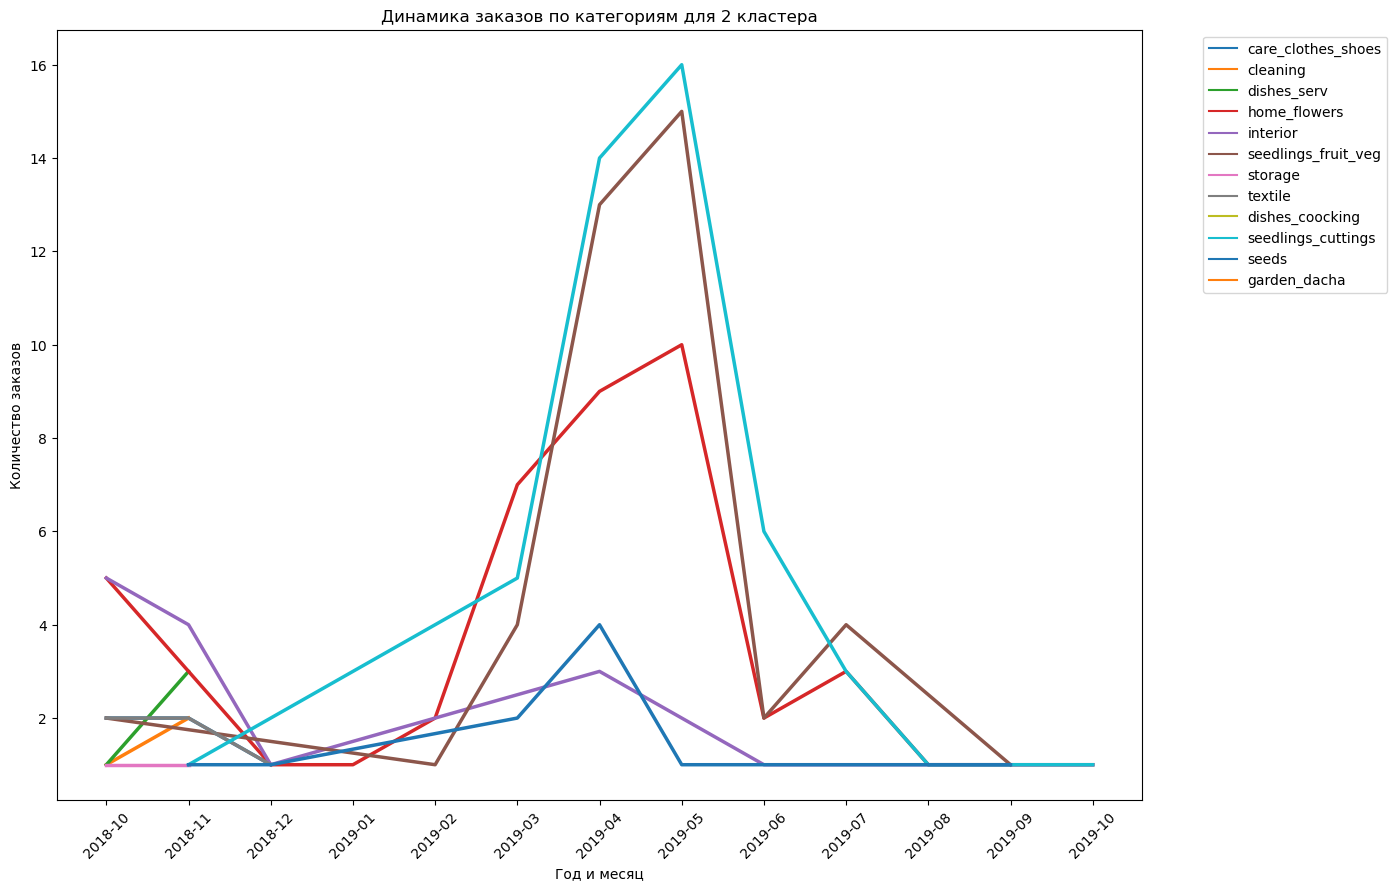

In [167]:
cluster2_categories = df_final.loc[df_final['cluster_km'] == 2].groupby(['year_month', 'category']).agg({'order_id':'nunique', 'order_price': 'sum'}).reset_index()

# Преобразование столбца 'year_month' в строковый формат
cluster2_categories['year_month'] = cluster2_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='category', data=cluster2_categories, palette='tab10', linewidth=2.5)
plt.title('Динамика заказов по категориям для 2 кластера')
plt.xlabel('Год и месяц')
plt.ylabel('Количество заказов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- Как будто клиенты вообще сделали разовые заказы и ушли.
- Закупили рассаду, в основном (растения и овощи/фрукты/зелень) + домашние цветы. Интересно, что на протяжении февраля-июня количество заказов очень хорошо росло.

In [168]:
cluster2_top_categories = df_final.loc[df_final['cluster_km'] == 2].groupby('category').agg({'order_id':'nunique', 'order_price': 'sum'}).sort_values(by=['order_id', 'order_price'], ascending=False).head(5).reset_index()
cluster2_top_categories

,category,order_id,order_price
0,seedlings_cuttings,47,816929.0
1,home_flowers,46,576684.0
2,seedlings_fruit_veg,42,859604.0
3,interior,15,181252.0
4,seeds,10,47334.0


In [169]:
cluster2_top5_products = df_final[df_final['category'].\
                                  isin(cluster2_top_categories['category'])].groupby(['category', 'product']).\
                                  size().reset_index(name='count').\
                                  sort_values(by='count', ascending=False).head(30)
cluster2_top5_products

,category,product,count
147,home_flowers,пеларгония розебудная red pandora укорененный ...,66
145,home_flowers,пеларгония розебудная prins nikolai укорененны...,56
120,home_flowers,пеларгония зональная диам. 12 см сиреневый пол...,53
144,home_flowers,пеларгония розебудная mary укорененный черенок,40
143,home_flowers,пеларгония розебудная margaretha укорененный ч...,31
146,home_flowers,пеларгония розебудная queen ingrid укорененный...,31
128,home_flowers,пеларгония зональная махровая лососевая,25
134,home_flowers,пеларгония зональная ринго вайт d-7 см h-10 см...,25
101,home_flowers,пеларгония зональная диам. 12 см коралловая по...,24
122,home_flowers,пеларгония зональная диам. 12 см темнорозовая ...,22


Во 2 кластере покупают, в основном, только цветы и рассаду. Опять в лидерах пеларгония.

In [170]:
unique_dates = set()
order_count_by_date = {}

# Фильтрация DataFrame для первого кластера
df_cluster2 = df_final[df_final['cluster_km'] == 2]

for index, row in df_cluster2.iterrows():
    product_name = row['product']
    if 'петуния' in product_name.lower():
        order_date = row['year_month']
        unique_dates.add(order_date)

for date in unique_dates:
    order_count_by_date[date] = 0

for index, row in df_cluster2.iterrows():
    product_name = row['product']
    if 'петуния' in product_name.lower():
        order_date = row['year_month']
        order_count_by_date[order_date] += 1

print("Количество заказов с 'петуния' по датам для второго кластера:")
for date, count in order_count_by_date.items():
    print(f"Дата: {date}, Количество заказов: {count}")

Количество заказов с 'петуния' по датам для второго кластера:
Дата: 2019-06, Количество заказов: 18
Дата: 2019-04, Количество заказов: 39
Дата: 2018-11, Количество заказов: 1
Дата: 2019-08, Количество заказов: 1
Дата: 2019-05, Количество заказов: 50


Аналогично 0 кластеру - петунию покупают, в основном, в апреле и мае.

### Анализ по категориям и товарам для кластера 3

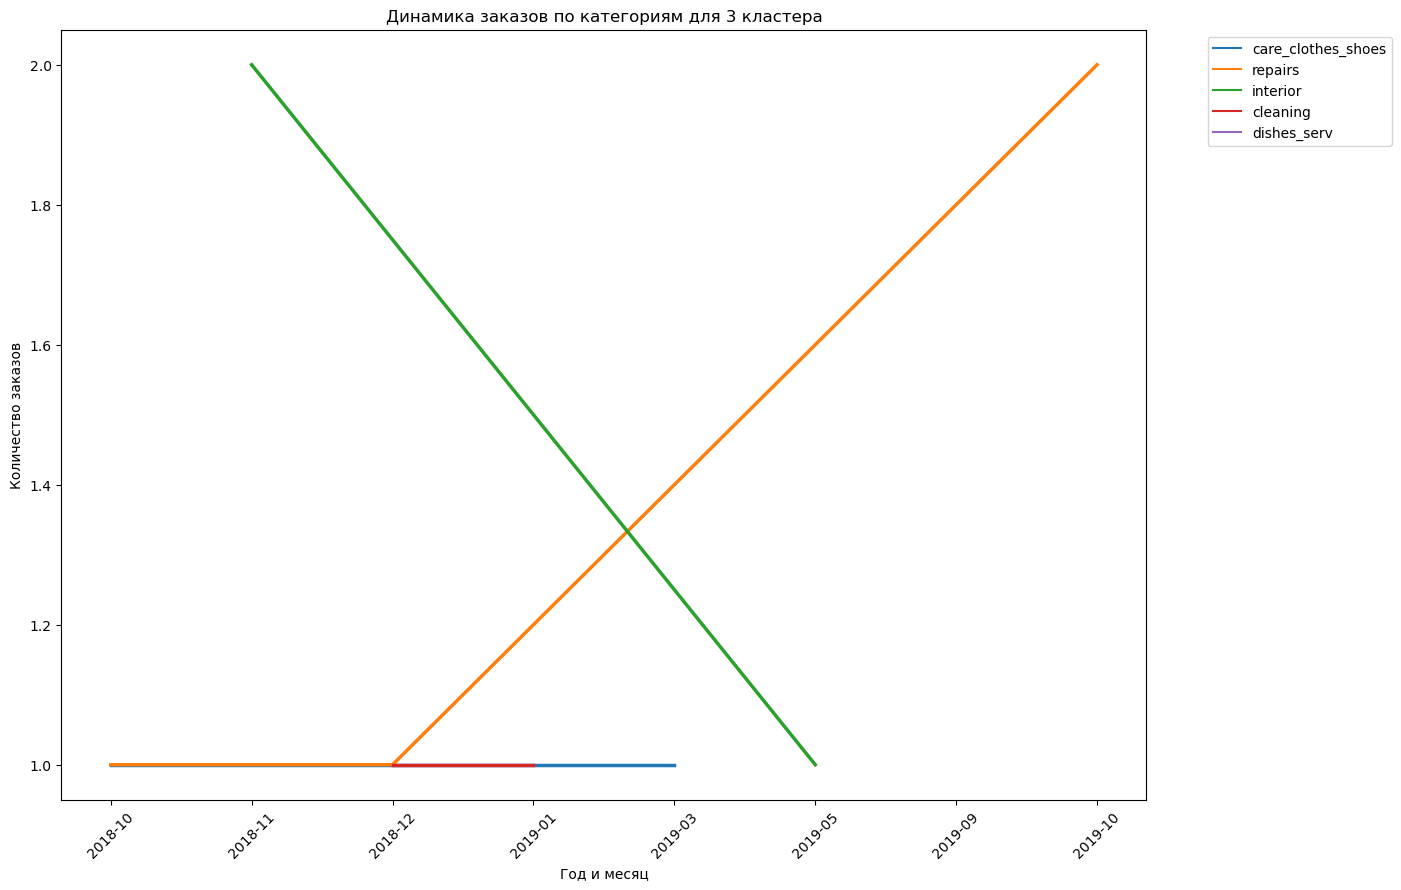

In [171]:
cluster3_categories = df_final.loc[df_final['cluster_km'] == 3].groupby(['year_month', 'category']).agg({'order_id':'nunique', 'order_price': 'sum'}).reset_index()

# Преобразование столбца 'year_month' в строковый формат
cluster3_categories['year_month'] = cluster3_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='order_id', hue='category', data=cluster3_categories, palette='tab10', linewidth=2.5)
plt.title('Динамика заказов по категориям для 3 кластера')
plt.xlabel('Год и месяц')
plt.ylabel('Количество заказов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- Тут слишком мало заказов, чтобы делать анализ, посмотрим на количество единиц товаров

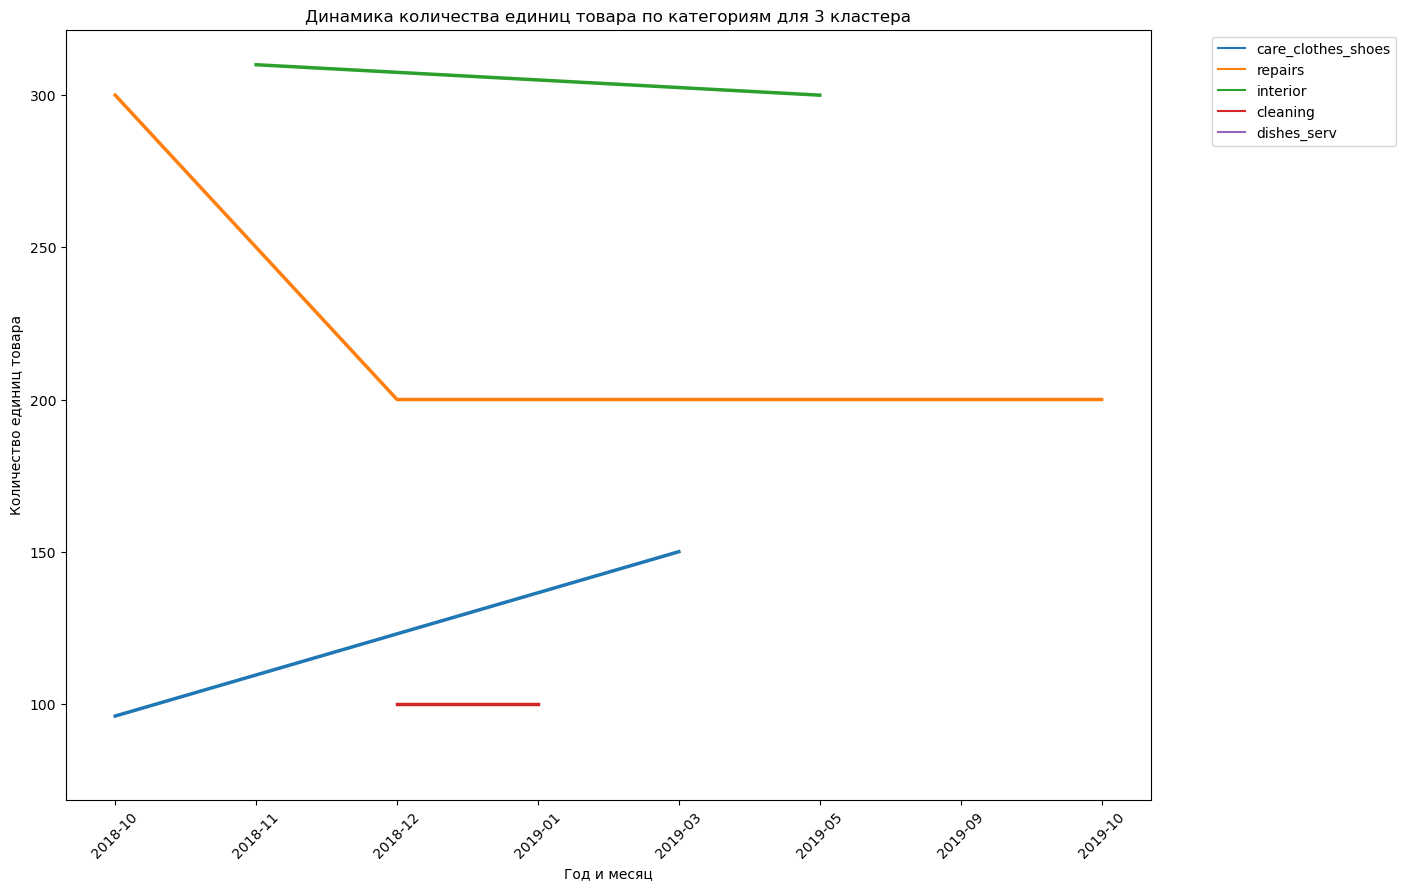

In [172]:
cluster3_new_categories = df_final.loc[df_final['cluster_km'] == 3].groupby(['year_month', 'category'])['quantity'].sum().reset_index()

# Преобразование столбца 'year_month' в строковый формат
cluster3_new_categories['year_month'] = cluster3_new_categories['year_month'].astype(str)

# Создание графика линий
plt.figure(figsize=(14, 10))
sns.lineplot(x='year_month', y='quantity', hue='category', data=cluster3_new_categories, palette='tab10', linewidth=2.5)
plt.title('Динамика количества единиц товара по категориям для 3 кластера')
plt.xlabel('Год и месяц')
plt.ylabel('Количество единиц товара')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

- В данном кластере представлены оптовые клиенты, которые покупают товары из категорий товаров для ухода за одеждой, ремонта, уборки

In [173]:
cluster3_top_categories = df_final.loc[df_final['cluster_km'] == 3].groupby('category').agg({'order_id':'nunique', 'order_price': 'sum'}).sort_values(by=['order_id', 'order_price'], ascending=False).head(5).reset_index()
cluster3_top_categories

,category,order_id,order_price
0,repairs,4,29200.0
1,interior,3,32230.0
2,care_clothes_shoes,2,6648.0
3,cleaning,2,6000.0
4,dishes_serv,1,3600.0


In [174]:
cluster3_top5_products = df_final[df_final['category'].\
                                  isin(cluster3_top_categories['category'])].groupby(['category', 'product']).\
                                  size().reset_index(name='count').\
                                  sort_values(by='count', ascending=False).head(30)
cluster3_top5_products

,category,product,count
213,care_clothes_shoes,сушилка для белья настенная zalger prima 510-7...,17
233,care_clothes_shoes,"сушилка для белья потолочная лиана 2,0 м 1703009",11
235,care_clothes_shoes,"сушилка для белья потолочная лиана 2,4 м 1703011",10
647,interior,муляж баклажан 18 см,10
410,cleaning,"таз пластмассовый со стиральной доской (иж), 1...",10
209,care_clothes_shoes,сушилка для белья напольная ника сбп1/с 18 м,9
602,interior,искусственная композиция из цветов пластиковая...,9
710,interior,"муляж яблоко, оранжевый, 8,5 см, полиуретан",8
698,interior,муляж персики мини полиуретан d-6 см,8
673,interior,муляж зеленое яблоко полиуретан d-6 см,8


In [175]:
cluster3_top5_products_q = df_final[df_final['category']
                                     .isin(cluster3_top_categories['category'])]\
                                     .groupby('product')\
                                     ['quantity'].sum()\
                                     .sort_values(ascending=False)\
                                     .head(30)
cluster3_top5_products_q 

product
муляж яблоко 9 см красное                                                                            618
ручка-скоба рс-100 белая *трибатрон*, 1108035                                                        201
муляж яблоко зеленый 9 см полиуретан                                                                 188
крепеж для пружины дверной, 1107055                                                                  170
плечики пластмассовые размер 52 - 54 тула 1205158                                                    160
пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014                                 150
муляж банан желтый 21 см полиуретан                                                                  109
щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096                       105
щетка для посуды *оля*, мультипласт 1807010                                                          101
стяжка оконная с болтом ст-55 цинк, 1108354    

Клиенты оптом закупают муляжи фруктов, искусственные цветы, наборы посуды, вешалки, мелкие товары для ремонта - шпингалеты, стяжки и тд.

# Общий вывод

**1. Предобработка:**

- пропусков в данных не обнаружено
- колонка date приведены к типу данных дата
- удалены 1920 строк неявных дубликатов, исходя из того, что в каждом заказе (order_id)  наименование товара (product) не повторяется
- названия колонок корректны и соответствуют данным, которые содержат
- строки столбца product приведены к нижнему регистру


**2. Исследовательский анализ данных:**

- добавили новые столбцы
- посчитали лояльных клиентов. Процент лояльных клиентов составляет около 42%, а нелояльных - 58%.
- посчитали для них кол-во дней с предыдущего заказа по отношению к текущему.
- выявили выбросы, но удалили точечные наблюдения
- У магазина наблюдается положительная динамика по количеству заказов
- Весна дачный сезон - подъем количества заказов. Также и период с сентября по январь
- Больше всего денег магазину за период наблюдений в среднем принесла категория товаров по уходу за одеждой и обувью, тележки на втором месте, на третьем - домашние цветы. Посуда для сервировки, мебель и товары для уборки принесли меньше всего выручки
- Лучше всего с точки зрения того, сколько тратят клиенты, категории: мебель (но не целевая категория товара для магазина), рассада цветов и черенки, тележки, рассада овощей и фруктов.
- Много заказов домашних цветов и расслады овощей и фруктов. А также рассады цветов и черенков.

**3. Кластеризация для сегментации клиентов:**

- Для кластеризации были выбраны такие признаки на клиента как: среднее количество купленных единиц товаров, среднее количество купленных наименований товаров, средняя стоимость товара.
- В качестве показателя количества кластеров была использована иерархическая кластеризация, визуализированная в виде дендрограммы. Метод показал 4 кластера. 
- Кластеризация была проведена с помощью модели k-means для значения 4.

**Проверка гипотез:**

- Правильность выделения кластеров была подтвреждена проверкой двух статистических гипотез:

- H0: Нет статистически значимых различий в средней стоимости заказа
- H1: Существуют статистически значимые различия в средней стоимости заказа

- H0: Нет статистически значимых различий в среднем количестве единиц товара, купленных одним покупателем, между кластерами
- H1: Существуют статистически значимые различия в среднем количестве единиц товара, купленных одним покупателем между кластерами


В результате проверки 2 гипотез было получено подтверждение значимых различий между кластерами (только кластеры 1 и 3 не отличаются по средней стоимости заказа).

**Описание кластеров и рекомендации:**

Кластер 0:
Описание: Кластер 0 является самым многочисленным по количеству покупателей (2124). Пик заказов приходится на зимнее время, и есть спад весной и летом. Весной и летом основные категории товаров, такие как домашние цветы и товары по уходу за одеждой и обувью, показывают спад продаж. Эти клиенты не покупают практически рассаду, но больше всего интересуются петуниями, сумками, тележками и сушилками для белья. Это лояльные клиенты, часто делают повторные заказы, но средний чек у них небольшой.
Рекомендации: Для этого кластера можно предложить сезонные скидки на популярные категории товаров во время спада продаж весной и летом. Также, стоит рассмотреть введение накопительной системы скидок, чтобы усилить лояльность клиентов.

Кластер 1:
Описание: В кластере 1 находится 202 клиента. Количество заказов в этом кластере распределено равномерно в течение всего года. Эти клиенты практически не интересуются цветами и растениями, а вместо этого покупают товары для ухода за одеждой и обувью (гладильные доски и сушилки), тележки/сумки и товары для уборки (тазы). Средний чек покупки в этом кластере высокий.
Рекомендации: Для клиентов из кластера 1 можно предлагать скидки на товары для дома с высокой ценой, такие как мебель, товары для ремонта или бытовая техника, чтобы максимизировать их средний чек.

Кластер 2:
Описание: Кластер 2 состоит из 89 клиентов, которые проявляют явный сезонный тренд активности, с активными покупками весной и осенью. Они заказывают рассаду растений, домашние цветы и рассаду овощей и фруктов (зелень). Количество товаров в заказе мало, но много наименований. Средняя цена наименования низкая, но средний чек покупки высокий.
Рекомендации: Для клиентов из кластера 2 можно предложить скидки на зимние домашние растения в ноябре-декабре, чтобы увеличить активность в зимний период.

Кластер 3:
Описание: Кластер 3 включает в себя всего 12 клиентов, которые являются оптовыми покупателями. Они делают мало заказов, но закупают большое количество наименований. Это оптовые точечные закупки определенных товаров из различных категорий. Цена одного наименования низкая, но средний чек покупки самый высокий среди всех кластеров.
Рекомендации: Для клиентов из кластера 3 необходимо разработать индивидуальную стратегию взаимодействия, возможно, предоставлять персонализированные предложения и учесть их потребности для увеличения оптовых продаж.